In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import kruskal
import scipy.stats as stats
import scikit_posthocs as sp
from scikit_posthocs import posthoc_dunn
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# 1. Zielsetzung der Analyse

Das primäre Ziel dieser Analyse besteht darin, die wesentlichen Einflussfaktoren auf Last-Minute-Flugpreise zu identifizieren und deren Wirkung quantitativ zu bemessen. Mithilfe statistischer Verfahren sollen Variablen ermittelt werden, die signifikante Auswirkungen auf den Preis haben. Dies ermöglicht eine tiefergehende Untersuchung der Preisbildungsmechanismen im Luftverkehr.

Dabei wird bewusst auf eine präzise Vorhersage des Flugpreises verzichtet, da die vorliegenden Daten nur einen Monat und Last-Minute-Flüge abdecken. Stattdessen steht das Verständnis der Preisfaktoren im Vordergrund, um Hypothesen für weiterführende Studien abzuleiten und künftige Analysen vorzubereiten.

# 2. Datenbereinigung

Im ersten Schritt der Analyse haben wir eine Datenbereinigung durchgeführt, um potenzielle Ausreißer in den Flugpreisen zu identifizieren und zu entfernen. Hierbei haben wir die **IQR-Methode (Interquartilsabstand)** angewendet, die sich insbesondere zur robusten Identifikation von Ausreißern eignet.

#### Interquartilsabstand (IQR)
Die IQR-Methode identifiziert Ausreißer, indem sie die mittleren 50 % der Daten betrachtet, also den Bereich zwischen dem 1. Quartil (25. Perzentil) und dem 3. Quartil (75. Perzentil). Der IQR ist die Differenz zwischen diesen beiden Werten:

$$
IQR = Q3 - Q1
$$

Ausreißer werden als Werte definiert, die mehr als das 1,5-fache des IQR oberhalb von $Q3$ oder unterhalb von $Q1$ liegen:

$$
\text{untere Grenze} = Q1 - 1.5 \cdot IQR
$$

$$
\text{obere Grenze} = Q3 + 1.5 \cdot IQR
$$

#### Anwendung auf Last-Minute-Flugpreise
Da es bei Last-Minute-Flugpreisen aufgrund von Angebot und Nachfrage zu extremen Preisschwankungen kommen kann, kann die Entfernung von Ausreißern helfen, den Einfluss besonders hoher oder niedriger Preise zu minimieren. Diese extremen Preise sind oft nicht repräsentativ für den allgemeinen Trend und könnten die Analyse verfälschen.

Durch die Bereinigung haben wir Flugpreise unter 100 € und über 1500 € entfernt, da diese als ungewöhnlich niedrig oder hoch galten und möglicherweise durch spezifische Faktoren bedingt waren, die nicht Teil unserer Analyse sind (z.B. kurzfristige Sonderaktionen oder stark begrenzte Sitzplatzverfügbarkeiten).


# 3. Feature-Analyse

In der Feature-Analyse haben wir den Einfluss einzelner Variablen auf die Flugpreise untersucht. Unser Ansatz war, zuerst eine deskriptive Statistik und visuelle Analyse der Features durchzuführen, gefolgt von Hypothesentests, um festzustellen, ob und welche Features signifikante Unterschiede in den Preisen verursachen.

1. **Deskriptive Statistik & KDE-Analyse**: Zunächst haben wir für jede relevante Variable die deskriptiven Statistiken berechnet und deren Verteilung mit der **KDE (Kernel Density Estimation)** visualisiert.
   
2. **Hypothesentests**: Anschließend haben wir mittels des **Kruskal-Wallis-Tests** überprüft, ob es signifikante Unterschiede in den Preisverteilungen der verschiedenen Feature-Gruppen gibt. Wo signifikante Unterschiede festgestellt wurden, folgte ein **Post-hoc Dunn-Test**, um die betroffenen Gruppen zu identifizieren.

---

#### Deskriptive Statistik & KDE-Analyse

Die deskriptive Statistik liefert uns eine Übersicht über zentrale Tendenzen und Streuungsmaße wie den Mittelwert, Median, Minimum, Maximum sowie Quartile jeder Variablen. Dies ermöglicht uns, erste Einblicke in die Verteilung der Daten zu gewinnen und Ausreißer oder besonders interessante Muster zu erkennen.

Die **Kernel Density Estimation (KDE)** ist eine nicht-parametrische Methode zur Schätzung der Wahrscheinlichkeitsdichtefunktion einer Variablen. Sie wird verwendet, um die zugrundeliegende Verteilung der Flugpreise in verschiedenen Kategorien der Features zu visualisieren. Die KDE-Formel basiert auf der Dichteabschätzung mittels eines Gaußschen Kerns:

$$
\hat{f}(x) = \frac{1}{nh} \sum_{i=1}^{n} K \left( \frac{x - x_i}{h} \right)
$$

Dabei ist:
- $n$ die Anzahl der Datenpunkte
- $h$ die Bandbreite, die die Glättung der Kurve beeinflusst
- $K(\cdot)$ die Kernel-Funktion, häufig ein Gaußscher Kern

Durch KDE-Plots können wir die Verteilung der Flugpreise in Abhängigkeit von verschiedenen Features, wie z.B. Zielkategorie, Abflugzeit oder Wetterbedingungen, visualisieren. Dies hilft uns, Muster zu erkennen und zu verstehen, welche Kategorien möglicherweise stärkere oder schwächere Einflüsse auf die Preisgestaltung haben.

---

##### Kruskal-Wallis-Test

Der **Kruskal-Wallis-Test** ist ein verallgemeinerter Rangsummentest, der verwendet wird, um mehr als zwei unabhängige Gruppen zu vergleichen. Da unsere Daten oft nicht normalverteilt sind, bietet sich der Kruskal-Wallis-Test an, weil er keine Annahmen über die Verteilung der Daten macht und somit robust gegenüber Ausreißern oder schiefen Verteilungen ist.

Die Nullhypothese ($H_0$) des Kruskal-Wallis-Tests lautet, dass die Verteilungen der Mediane aller Gruppen gleich sind. Die Alternative ($H_1$) besagt, dass mindestens eine Gruppe signifikant unterschiedliche Mediane aufweist. Wenn $H_0$ abgelehnt wird, wissen wir jedoch nur, dass es signifikante Unterschiede gibt, aber nicht, welche Gruppen sich konkret unterscheiden.

Mathematisch basiert der Kruskal-Wallis-Test auf den Rängen der Daten und der Teststatistik:

$$
H = \frac{12}{N(N+1)} \sum_{i=1}^{g} \frac{R_i^2}{n_i} - 3(N+1)
$$

Dabei ist:
- $N$ die Gesamtzahl der Beobachtungen,
- $g$ die Anzahl der Gruppen,
- $n_i$ die Anzahl der Beobachtungen in der Gruppe $i$,
- $R_i$ die Summe der Ränge in der Gruppe $i$.

Der Test vergleicht die Rangsumme der verschiedenen Gruppen. Ein großer Wert von $H$ deutet darauf hin, dass die Gruppen unterschiedlich sind. Der resultierende $p$-Wert gibt an, ob diese Unterschiede signifikant sind. Wenn $p < \alpha$ (mit $\alpha$ typischerweise 0.05), lehnen wir die Nullhypothese ab und führen einen weiteren Test durch.

**Allgemeine Hypothesen für den Kruskal-Wallis-Test**:
- $H_0$: Die Verteilungen der Mediane aller Kategorien innerhalb der beobachteten Gruppe sind gleich.
- $H_1$: Mindestens eine Kategorie der beobachteten Gruppe unterscheidet sich signifikant in ihrer Medianverteilung.

Wenn der Test ergibt, dass $H_0$ abgelehnt werden kann, deutet dies auf Unterschiede zwischen den Gruppen hin. Es bleibt jedoch offen, welche Gruppen sich genau unterscheiden.

---

##### Post-hoc Dunn-Test

Wenn der Kruskal-Wallis-Test signifikante Unterschiede zeigt, wird der **Post-hoc Dunn-Test** verwendet, um die Gruppen paarweise zu vergleichen und festzustellen, welche sich tatsächlich signifikant unterscheiden. Der Dunn-Test ist ein nicht-parametrischer Post-hoc-Test, der die Bonferroni-Korrektur verwendet, um das Risiko von Alpha-Fehlern (falsch positive Ergebnisse) zu minimieren, wenn mehrere paarweise Vergleiche durchgeführt werden.

Mathematisch basiert der Dunn-Test ebenfalls auf Rängen und testet die paarweisen Differenzen der Rangsummen zwischen den Gruppen. Er berechnet für jedes Paar von Gruppen einen Z-Wert und anschließend einen $p$-Wert, um zu entscheiden, ob die Unterschiede signifikant sind.

Die Teststatistik für den Vergleich zweier Gruppen $i$ und $j$ lautet:

$$
Z = \frac{R_i - R_j}{\sqrt{\left( \frac{N(N+1)}{12} \right) \left( \frac{1}{n_i} + \frac{1}{n_j} \right)}}
$$

Der $Z$-Wert gibt an, wie stark die Differenz der Rangsummen von $i$ und $j$ ist. Ein hoher absoluter $Z$-Wert zeigt größere Unterschiede an. Der Dunn-Test liefert uns also detaillierte Informationen darüber, zwischen welchen spezifischen Gruppen signifikante Unterschiede bestehen.

**Allgemeine Hypothesen für den Post-hoc Dunn-Test**:
- $H_0$: Es gibt keine signifikanten Unterschiede in den Medians zwischen den verglichenen Gruppen.
- $H_1$: Es gibt signifikante Unterschiede in den Medians zwischen den verglichenen Gruppen.

---
**Beispiel**:
Nachdem der Kruskal-Wallis-Test signifikante Unterschiede zwischen den Transitgruppen festgestellt hat, können wir mit dem Dunn-Test genauer herausfinden, welche Gruppen sich unterscheiden. Wenn z.B. die Gruppen "kurz" und "mittel" signifikant verschiedene Preise haben, aber "kurz" und "lang" nicht, fassen wir die Transitgruppen neu zusammen, um die Modellkomplexität zu reduzieren.

---

##### Numerische Variablen in Gruppen einteilen

Obwohl einige unserer Variablen ursprünglich numerisch sind (z.B. Temperatur oder Transitzeit), haben wir diese für die Hypothesentests in Kategorien unterteilt. Dies bietet mehrere Vorteile:

1. **Interpretierbarkeit**: Die Ergebnisse sind leichter zu interpretieren, wenn wir wissen, dass z.B. "hohe" Temperaturen signifikant anders sind als "niedrige" Temperaturen, anstatt eine kontinuierliche Variable zu betrachten.
2. **Modellkomplexität reduzieren**: Indem wir Gruppen bilden, fassen wir ähnliche Werte zusammen und verringern die Anzahl der zu testenden und zu modellierenden Werte, was die Komplexität reduziert.
3. **Hypothesentests**: Viele Hypothesentests, wie der Kruskal-Wallis-Test, sind für den Vergleich von Gruppen ausgelegt. Eine Gruppierung ermöglicht also den Einsatz dieser Methoden, um signifikante Unterschiede zu finden.
4. **Erweiterte Analyse**: Selbst wenn wir diese Variablen später im Modell wieder kontinuierlich verwenden, liefert uns die Gruppierung zusätzliche Informationen darüber, ob und wie sich bestimmte Kategorien signifikant unterscheiden. Dies hilft uns, die Modellierung sinnvoller zu gestalten.

---

Insgesamt haben wir durch die Kombination des Kruskal-Wallis-Tests und des Post-hoc Dunn-Tests eine robuste Methode zur Untersuchung der Einflussfaktoren entwickelt. Wenn der Kruskal-Wallis-Test keine signifikanten Unterschiede aufweist, betrachten wir die Variable als irrelevant für die Preisgestaltung. Falls signifikante Unterschiede vorhanden sind, verfeinern wir die Einteilung der Gruppen und fassen ähnliche Kategorien zusammen, um die Modellkomplexität gering zu halten und die Erklärbarkeit zu maximieren.

# 4. Quantifizierung der Features mittels Regressionsanalyse

Nachdem wir durch die Hypothesentests signifikante Unterschiede zwischen verschiedenen Feature-Kategorien festgestellt haben, war unser Ziel, zu quantifizieren, **wie stark die einzelnen Features den Preis beeinflussen**. Um dies zu erreichen, haben wir uns für eine **lineare Regressionsanalyse** entschieden. Dabei wollten wir nicht unbedingt ein Modell entwickeln, das den Preis perfekt vorhersagt, sondern vielmehr verstehen, welche Features wie stark mit den Flugpreisen zusammenhängen.

---

##### Lineare Regression als Methode zur Feature-Analyse

Die **lineare Regression** ist ein statistisches Verfahren, das die Beziehung zwischen einer abhängigen Variablen (hier: Preis) und einer oder mehreren unabhängigen Variablen (hier: unsere Features) modelliert. Dabei wird angenommen, dass diese Beziehung durch eine lineare Funktion beschrieben werden kann.

Mathematisch sieht das lineare Regressionsmodell wie folgt aus:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
$$

Hierbei sind:
- $y$: Die abhängige Variable (Flugpreis),
- $x_1, x_2, \dots, x_n$: Die unabhängigen Variablen (unsere ausgewählten Features),
- $\beta_0$: Der Achsenabschnitt (Intercept),
- $\beta_1, \dots, \beta_n$: Die Koeffizienten der unabhängigen Variablen, die den Einfluss dieser Features auf $y$ beschreiben,
- $\epsilon$: Der Fehlerterm, der die Abweichung der tatsächlichen Preise von den vorhergesagten Werten beschreibt.

Die Koeffizienten $\beta_1, \dots, \beta_n$ sind besonders wichtig für uns, da sie quantifizieren, **wie stark** und **in welcher Richtung** (positiv oder negativ) die einzelnen Features den Flugpreis beeinflussen. Ein positiver Koeffizient zeigt an, dass das Feature den Preis erhöht, während ein negativer Koeffizient auf eine preissenkende Wirkung hindeutet.

Wir haben uns bewusst für die lineare Regression entschieden, da:
1. Sie eine klare und interpretierbare Beziehung zwischen den Variablen herstellt.
2. Unser Ziel darin besteht, die Auswirkungen der Features zu bewerten und nicht unbedingt eine präzise Vorhersage zu machen.
3. Sie gut geeignet ist, um die Bedeutung und das Gewicht der einzelnen Features aufzuzeigen.

---

##### Mathematische Prinzipien hinter der Regressionsanalyse

Das Ziel der linearen Regression ist es, die Koeffizienten $\beta_0, \beta_1, \dots, \beta_n$ so zu bestimmen, dass die Summe der quadratischen Abweichungen zwischen den beobachteten Werten und den durch das Modell vorhergesagten Werten minimiert wird. Dies geschieht durch die Minimierung der sogenannten **Fehlersumme der Quadrate (Residual Sum of Squares, RSS)**:

$$
RSS = \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

wobei:
- $y_i$: der tatsächliche Preis für den $i$-ten Flug ist,
- $\hat{y}_i$: der durch das Modell vorhergesagte Preis für den $i$-ten Flug.

Das Verfahren der **kleinsten Quadrate** (Ordinary Least Squares, OLS) wird verwendet, um diese Summe zu minimieren und so die optimalen Koeffizienten $\beta_1, \dots, \beta_n$ zu finden.

---

##### Bestimmtheitsmaß ($R^2$)

Um die Güte unseres Modells zu bewerten, haben wir das **Bestimmtheitsmaß** ($R^2$) herangezogen. $R^2$ gibt an, wie viel der Varianz der abhängigen Variablen (also des Preises) durch die unabhängigen Variablen (unsere Features) erklärt werden kann. Es wird wie folgt berechnet:

$$
R^2 = 1 - \frac{RSS}{TSS}
$$

wobei:
- $RSS$ die Fehlersumme der Quadrate ist (siehe oben),
- $TSS$ die **Totale Summe der Quadrate** ist, welche die Gesamtvarianz des Preises beschreibt:

$$
TSS = \sum_{i=1}^{N} (y_i - \bar{y})^2
$$

$R^2$ liegt immer zwischen 0 und 1:
- Ein $R^2$ von 0 bedeutet, dass das Modell keine Varianz der abhängigen Variablen erklären kann.
- Ein $R^2$ von 1 bedeutet, dass das Modell die gesamte Varianz der abhängigen Variablen perfekt erklärt.

In unserem Kontext war das Bestimmtheitsmaß von besonderer Bedeutung, da wir wissen wollten, **wie gut unsere Features die Preisschwankungen erklären können**. Ein hohes $R^2$ bedeutet, dass unser Modell und die gewählten Features die Preisunterschiede gut beschreiben. Allerdings sollte beachtet werden, dass ein hohes $R^2$ nicht automatisch ein perfektes Modell impliziert – insbesondere dann, wenn Overfitting eine Rolle spielt.

---

##### Interpretation der Ergebnisse und Feature-Bewertung

Durch die lineare Regression konnten wir feststellen, **welche Features** den größten Einfluss auf den Preis haben und in welchem **Ausmaß** sie dies tun. Die Koeffizienten der unabhängigen Variablen geben uns direkte Informationen darüber, **wie stark und in welche Richtung** jedes Feature den Preis beeinflusst. Beispielsweise kann ein negativer Koeffizient bedeuten, dass ein Feature wie "Transitzeit" den Preis verringert, während ein positiver Koeffizient für "Destination Inland" zeigt, dass Inlandflüge tendenziell teurer sind.

Wichtig für unsere Analyse war nicht die Vorhersagegenauigkeit des Modells, sondern die **Bedeutung der einzelnen Features**. Deshalb war das $R^2$-Maß in unserem Fall eher ein Indikator dafür, **wie viel der Preisschwankungen durch die gewählten Variablen erklärt werden kann**. Auch die **Koeffizienten** spielten eine zentrale Rolle, da sie uns einen quantitativen Eindruck über den Einfluss der einzelnen Features auf den Preis lieferten.

Am Ende der Analyse haben wir nicht nur die **signifikanten Features** identifiziert, sondern auch verstanden, wie stark sich diese auf die Preisgestaltung auswirken, was wertvolle Hinweise für weitere, tiefergehende Analysen bietet.


# 5. Limitationen und kritische Reflexion

Bei der Durchführung dieser Analyse war uns von Anfang an bewusst, dass unser Ansatz und die verwendeten Methoden einige Limitationen aufweisen. In diesem Abschnitt wollen wir diese Limitationen diskutieren und gleichzeitig erklären, warum wir uns im Rahmen der gegebenen Daten und des Moduls bewusst für diese Vorgehensweise entschieden haben. Ziel war es, eine **erste umfassende Betrachtung der gesammelten Daten** vorzunehmen und mögliche Einflussfaktoren auf die Flugpreise zu identifizieren, ohne direkt ein generalisierbares Modell zu entwickeln.

---

#### Limitation der Datenbasis

Eine der größten Limitationen dieser Analyse ist die **Datenbasis**. Wir arbeiten hier mit **Last-Minute-Preisen**, die nur über einen Zeitraum von 30 Tagen erhoben wurden, und das auch nur für **vier Airlines**. Diese eingeschränkte Datenmenge stellt ein zentrales Problem dar, da die Flugpreise stark saisonalen Schwankungen unterliegen können, die wir nicht abbilden konnten. In einem breiter angelegten Datensatz, der mehrere Monate oder sogar Jahre umfasst, könnten andere Muster oder Einflüsse sichtbar werden.

Darüber hinaus haben wir nicht genügend Daten, um eine verlässliche Aussage über **seltene Ereignisse** oder **extreme Preisschwankungen** treffen zu können, da die Datenerhebung ausschließlich auf einem eng umrissenen Zeitraum basiert. Dies beeinflusst nicht nur die Generalisierbarkeit unserer Ergebnisse, sondern auch die Möglichkeiten der Modellbildung. In zukünftigen Analysen wäre es wichtig, **mehr Daten** über einen längeren Zeitraum und für **weitere Airlines** zu sammeln.

---

#### Isolierte Betrachtung der Features

In dieser Analyse haben wir uns darauf konzentriert, die **einzelnen Einflussfaktoren isoliert zu betrachten**. Das bedeutet, dass wir die Auswirkungen von Features wie "Transitzeit", "Ankunftszeit" oder "Windgeschwindigkeit" unabhängig voneinander auf den Flugpreis untersucht haben. Dieser Ansatz hat klare Vorteile in Bezug auf die Interpretierbarkeit und die Reduzierung der Modellkomplexität, bringt aber auch einige Schwächen mit sich.

In der Realität wirken viele dieser Faktoren **gemeinsam und in Abhängigkeit voneinander**. So könnte die Transitzeit beispielsweise in Kombination mit der Airline oder dem Wochentag zu unterschiedlichen Preisänderungen führen. Solche **Interaktionen zwischen den Features** wurden in dieser Analyse bewusst nicht untersucht, um die Analyse fokussiert und verständlich zu halten. Für eine tiefergehende Untersuchung wäre es allerdings sinnvoll, **mehrdimensionale Interaktionen** zu betrachten, beispielsweise durch die Verwendung von Modellen, die Wechselwirkungen zwischen den Variablen besser erfassen, wie etwa **Interaktionsmodelle** oder **nicht-lineare Methoden**.

---

#### Wahl der statistischen Tests

Ein weiterer Kritikpunkt könnte die Wahl der **Kruskal-Wallis-Tests** und der anschließenden **Post-hoc Dunn-Tests** zur Analyse der Features sein. Diese Tests sind darauf ausgelegt, Unterschiede zwischen den **Kategorien eines Features** zu erkennen. Sie haben den Vorteil, dass sie keine Annahmen über die Verteilung der Daten machen, was sie robust für nicht-normal verteilte Daten macht. In unserem Fall ist dies ideal, da **Flugpreise oft nicht normal verteilt sind**.

Allerdings haben wir uns bewusst auf die Untersuchung von **Unterschieden zwischen den Gruppen eines Features** beschränkt, ohne dabei Interaktionen zwischen den Features zu berücksichtigen. In zukünftigen Studien könnte es sinnvoll sein, **multivariate Tests** oder **kombinatorische Ansätze** zu verwenden, die die Wechselwirkungen zwischen den Features explizit mit einbeziehen. Zudem könnten andere Verfahren zur Feature-Analyse, wie etwa **Random Forests**, **logistische Regressionen** oder **Support Vector Machines (SVMs)**, eingesetzt werden, um die Beziehungen zwischen den Variablen genauer zu untersuchen.

---

#### Einsatz der linearen Regression

Die Entscheidung, eine **lineare Regression** zu verwenden, basiert auf dem Ziel, die **Einflüsse der einzelnen Features** auf den Preis zu quantifizieren und die Modellierung möglichst einfach und verständlich zu halten. Dabei war es uns wichtig, die **Koeffizienten der einzelnen Features** zu interpretieren und zu verstehen, wie sich diese auf den Preis auswirken.

Natürlich hätte man auch **nicht-lineare Beziehungen** untersuchen können, wie etwa **quadratische oder exponentielle Modelle**. Diese könnten in einigen Fällen die Realität besser abbilden, da sich der Einfluss eines Features nicht immer linear verhält. Ein solcher Ansatz wäre jedoch **komplexer** und weniger interpretierbar, was nicht mit unserem Ziel übereinstimmte. Zudem wäre dies angesichts der begrenzten Datenbasis riskant gewesen, da komplexere Modelle tendenziell stärker zum **Overfitting** neigen, wenn nicht genügend Daten vorliegen.

---

#### Einschränkungen durch Overfitting und Generalisierbarkeit

Während wir unser Modell auf die verfügbaren Daten angepasst haben, besteht das Risiko des **Overfittings**. Dies bedeutet, dass das Modell die vorhandenen Daten zwar gut beschreibt, aber bei neuen Daten nur unzureichende Vorhersagen machen könnte. Dies ist insbesondere ein Problem, wenn das Modell zu viele Details aus den Trainingsdaten lernt, die nicht generalisierbar sind. Um Overfitting zu minimieren, haben wir versucht, die Komplexität des Modells durch die Reduktion der Features und die Anwendung von Cross-Validation zu kontrollieren. Dennoch bleibt dies eine Limitation, da unsere Datenmenge insgesamt sehr klein ist und sich die Ergebnisse möglicherweise nicht auf größere Datensätze übertragen lassen.

---

#### Zukünftige Untersuchungen und Möglichkeiten

Trotz der genannten Limitationen bietet unsere Analyse erste interessante Einblicke in die Faktoren, die den Flugpreis beeinflussen. Zukünftig wäre es sinnvoll, diese Untersuchung auf einen **größeren und repräsentativeren Datensatz** auszuweiten, um robustere und generalisierbarere Ergebnisse zu erhalten. Außerdem könnten **alternative Modellierungsansätze** (z.B. Random Forests, Gradient Boosting) verwendet werden, um auch komplexere Zusammenhänge zwischen den Features zu erfassen.

Zusammenfassend lässt sich sagen, dass die durchgeführte Analyse als eine **erste Vorstudie** dient, die wichtige Anhaltspunkte für **weiterführende Untersuchungen** liefert. Sie zeigt auf, welche Features einen Einfluss auf die Flugpreise haben könnten und legt den Grundstein für zukünftige Studien, in denen komplexere Zusammenhänge und größere Datenmengen untersucht werden können.


In [2]:
df = pd.read_csv('analysis_dataset.csv')
# Unnamed: 0 Spalte entfernen
df = df.drop(columns=['Unnamed: 0'])

In [3]:
# Funktion zur Bereinigung der Zahlenstrings
def clean_numeric_string(value):
    if isinstance(value, str):
        # Entferne alle nicht-numerischen Zeichen außer dem letzten Punkt
        value = value.replace(',', '')  # Entferne Kommas
        value = value.replace(' ', '')  # Entferne Leerzeichen
        value = value.replace('-', '')  # Entferne Minuszeichen, wenn es nicht ein negatives Vorzeichen ist
        parts = value.split('.')
        if len(parts) > 2:
            value = ''.join(parts[:-1]) + '.' + parts[-1]
        value = ''.join([c for c in value if c.isdigit() or c == '.'])  # Nur Ziffern und Punkte behalten
    return value

# Liste der Spalten, die in float konvertiert werden sollen
float_columns = [
    'price', 'tavg_departure', 'tmin_departure', 'tmax_departure', 'prcp_departure',
    'wdir_departure', 'wspd_departure', 'wpgt_departure', 'pres_departure',
    'tavg_destination', 'tmin_destination', 'tmax_destination',
    'prcp_destination', 'wdir_destination', 'wspd_destination',
    'wpgt_destination', 'pres_destination', 'Open', 'High', 'Low', 'Close',
    'Adj Close', 'Volume'
]

# Bereinigen und Konvertieren der genannten Spalten in float
df[float_columns] = df[float_columns].applymap(clean_numeric_string)

# Ersetzen von leeren Werten durch 0
df[float_columns] = df[float_columns].replace('', '0')

# Konvertierung in Float
df[float_columns] = df[float_columns].astype(float)

# Wochentag extrahieren (0 = Montag, 6 = Sonntag)
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.dayofweek

# Wochentag in eine verständliche Form umwandeln (Montag, Dienstag,...)
df['weekday_name'] = df['date'].dt.day_name()

# Ausreißer

In [4]:
# Schritt 1: Berechnung des IQR für die Preisspalte
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Schritt 2: Definition der unteren und oberen Grenze für akzeptable Werte
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Schritt 3: Entfernen der Ausreißer
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Wochentage

### Wochentage und Flugpreise

#### Deskriptive Statistik:
Hier haben wir die Verteilung der Flugpreise nach Wochentagen untersucht. Im Mittel bewegen sich die Preise der verschiedenen Wochentage relativ nah beieinander. Die höchsten durchschnittlichen Preise finden wir am **Dienstag** (705,78 €) und **Freitag** (705,07 €), während der **Mittwoch** (668,21 €) und **Sonntag** (688,89 €) zu den Tagen mit den niedrigeren Preisen zählen.

| Wochentag  | Durchschnittlicher Preis (€) | Standardabweichung (€) |
|------------|-----------------------------|------------------------|
| Montag     | 693,68                       | 506,22                 |
| Dienstag   | 705,78                       | 504,76                 |
| Mittwoch   | 668,21                       | 542,05                 |
| Donnerstag | 699,02                       | 543,56                 |
| Freitag    | 705,07                       | 581,42                 |
| Samstag    | 690,18                       | 588,03                 |
| Sonntag    | 688,89                       | 559,99                 |

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** zwischen den Flugpreisen an den verschiedenen Wochentagen.  
**H1**: Mindestens ein Wochentag unterscheidet sich signifikant in Bezug auf die Flugpreise.

#### Kruskal-Wallis-Test:
Um diese Hypothese zu testen, haben wir den Kruskal-Wallis-Test durchgeführt, der sich gut eignet, um die Preise über mehrere Gruppen zu vergleichen, ohne die Annahme der Normalverteilung. 

- **Kruskal-Wallis-Statistik**: 3.59
- **P-Wert**: 0.731

Da der P-Wert größer als 0.05 ist, können wir die Nullhypothese **nicht ablehnen**. Das bedeutet, dass wir keine signifikanten Unterschiede in den Flugpreisen zwischen den Wochentagen feststellen konnten.

#### Schlussfolgerung:
Die Wochentage scheinen **keinen signifikanten Einfluss** auf die Flugpreise in unseren Daten zu haben. Es ist daher nicht nötig, einen Post-hoc-Test durchzuführen, da der Kruskal-Wallis-Test keine signifikanten Unterschiede aufzeigt.


In [5]:
# Wochentage in der gewünschten Reihenfolge festlegen
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Deskriptive Statistik der Flugpreise nach Wochentagen berechnen
key_metrics = df.groupby('weekday_name')['price'].describe()

# Sortieren der Statistik nach der Wochentagsreihenfolge
key_metrics = key_metrics.reindex(weekday_order)

# Ausgabe der deskriptiven Statistik
key_metrics

,count,mean,std,min,25%,50%,75%,max
weekday_name,,,,,,,,
Monday,92.0,693.680652,506.223633,1.043,313.0800,446.5,1056.0000,1601.42
Tuesday,122.0,705.784762,504.762721,1.009,315.9800,519.0,1017.1825,2037.00
Wednesday,121.0,668.210215,542.049292,1.009,313.0800,369.0,1011.4900,2725.00
Thursday,121.0,699.024479,543.560170,1.008,313.0800,487.0,1019.9200,2098.00
Friday,122.0,705.066566,581.421656,1.037,246.2375,510.5,1109.9925,2707.00
Saturday,121.0,690.182050,588.030933,0.000,241.0800,520.0,1243.0000,2708.00
Sunday,90.0,688.893311,559.989785,1.021,238.4700,486.0,1295.0000,1713.90


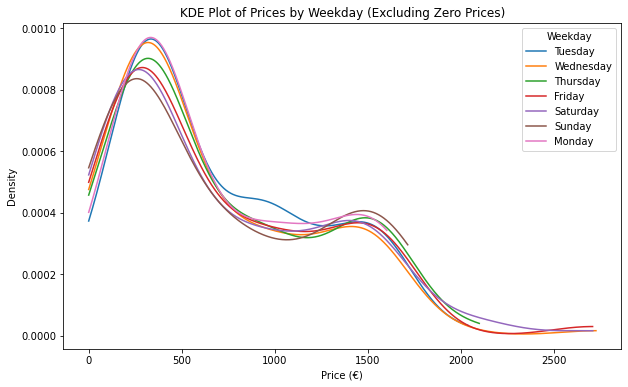

In [6]:
# KDE-Plot ohne negative Werte erzwingen
plt.figure(figsize=(10, 6))

# Filtern der Daten, um sicherzustellen, dass nur positive Preise verwendet werden
filtered_df = df[df['price'] > 0]

# Plotten der KDE für jeden Wochentag
for weekday in filtered_df['weekday_name'].unique():
    subset = filtered_df[filtered_df['weekday_name'] == weekday]['price']
    
    # Dichte schätzen mit scipy
    kde = gaussian_kde(subset)
    price_range = np.linspace(0, subset.max(), 1000)
    density = kde(price_range)
    
    # Sicherstellen, dass keine negativen Dichten angezeigt werden
    density[density < 0] = 0
    
    plt.plot(price_range, density, label=weekday)

plt.title('KDE Plot of Prices by Weekday (Excluding Zero Prices)')
plt.xlabel('Price (€)')
plt.ylabel('Density')
plt.legend(title='Weekday')
plt.show()

In [7]:
# Daten nach Wochentagen gruppieren
prices_monday = df[df['weekday_name'] == 'Monday']['price']
prices_tuesday = df[df['weekday_name'] == 'Tuesday']['price']
prices_wednesday = df[df['weekday_name'] == 'Wednesday']['price']
prices_thursday = df[df['weekday_name'] == 'Thursday']['price']
prices_friday = df[df['weekday_name'] == 'Friday']['price']
prices_saturday = df[df['weekday_name'] == 'Saturday']['price']
prices_sunday = df[df['weekday_name'] == 'Sunday']['price']

# Durchführung des Kruskal-Wallis-Tests
statistic, p_value = kruskal(
    prices_monday,
    prices_tuesday,
    prices_wednesday,
    prices_thursday,
    prices_friday,
    prices_saturday,
    prices_sunday
)

print(f"Kruskal-Wallis-Statistik: {statistic}")
print(f"P-Wert: {p_value}")

Kruskal-Wallis-Statistik: 3.59365567888589
P-Wert: 0.7314703898503425


#  Zielort

### Zielort und Flugpreise

#### Deskriptive Statistik:
In dieser Analyse haben wir die Zielorte in drei Kategorien unterteilt: **Inland**, **Europa**, und **International**. Diese Zusammenfassung wurde vorgenommen, um die Zielorte in größere, sinnvolle Gruppen zu gliedern. Interessanterweise zeigen die Flugpreise deutliche Unterschiede zwischen diesen Kategorien. 

Es ist jedoch wichtig zu beachten, dass einige hohe Inlandspreise darauf zurückzuführen sind, dass bestimmte Airlines, wie **Qatar Airways**, Flüge von Frankfurt nach Berlin über Doha leiten. Dies führt zu extrem hohen Preisen für eigentlich kurze Inlandsstrecken, weshalb diese Daten mit Vorsicht betrachtet werden sollten.

| Zielkategorie   | Anzahl | Durchschnittlicher Preis (€) | Standardabweichung (€) | Median (€) | Q1 (€)  | Q3 (€)  | Max (€)   |
|-----------------|--------|-----------------------------|------------------------|------------|---------|---------|-----------|
| Europa          | 104    | 350.31                      | 326.72                 | 273.52     | 235.56  | 548.00  | 1713.90   |
| Inland          | 284    | 553.77                      | 460.21                 | 333.60     | 241.08  | 923.75  | 1923.00   |
| International   | 401    | 880.77                      | 575.54                 | 819.00     | 315.98  | 1521.76 | 2725.00   |

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den drei Zielortkategorien (Inland, Europa, International).  
**H1**: Mindestens eine Zielortkategorie führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Mit dem Kruskal-Wallis-Test haben wir überprüft, ob es signifikante Unterschiede zwischen den drei Zielortkategorien gibt.

- **Kruskal-Wallis-Statistik**: 120.92
- **P-Wert**: 5.52e-27

Der extrem niedrige P-Wert lässt uns die Nullhypothese ablehnen. Dies zeigt, dass die Flugpreise zwischen den Zielkategorien signifikant variieren. 

#### Post-hoc Dunn-Test:
Da der Kruskal-Wallis-Test signifikante Unterschiede nachgewiesen hat, haben wir den Post-hoc Dunn-Test durchgeführt, um festzustellen, welche Gruppen sich signifikant unterscheiden.

| Vergleich        | P-Wert         | Signifikanz |
|------------------|----------------|-------------|
| Europa - Inland  | 4.59e-04       | Signifikant |
| Europa - International | 3.28e-21  | Signifikant |
| Inland - International | 4.40e-15  | Signifikant |

Alle drei Gruppen (Europa, Inland, International) unterscheiden sich **signifikant** voneinander, was bestätigt, dass unsere Gruppierung sinnvoll ist und keine weiteren Anpassungen erforderlich sind.

#### Schlussfolgerung:
Es gibt **signifikante Unterschiede** in den Flugpreisen basierend auf der Zielortkategorie. Internationale Flüge sind im Durchschnitt teurer, während europäische Ziele tendenziell die günstigsten Preise aufweisen. Diese Ergebnisse unterstreichen, dass die Zielkategorie ein entscheidender Faktor für die Flugpreise ist, und die Unterteilung in die drei Kategorien sinnvoll bleibt.

In [8]:
# Funktion zur Kategorisierung des Zielorts nach Flughafen
def categorize_destination(airport_code):
    if airport_code in ['BER', 'HAM', 'MUC']:  # Inlandsflughäfen
        return 'Inland'
    elif airport_code in ['LHR', 'CDG', 'AMS']:  # Europäische Flughäfen
        return 'Europa'
    else:
        return 'International'

# Anwendung der Kategorisierung auf den Datensatz
df['destination_category'] = df['destination_airport'].apply(categorize_destination)

# Berechnung der deskriptiven Statistiken für jede Zielkategorie
stats_by_destination_category = df.groupby('destination_category').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
).reset_index()

# Ausgabe der deskriptiven Statistiken
stats_by_destination_category

,destination_category,count,mean,std,min,q25,median,q75,max
0,Europa,104,350.313346,326.721105,1.142,235.5575,273.52,548.00,1713.9
1,Inland,284,553.765651,460.208279,0.000,241.0800,333.60,923.75,1923.0
2,International,401,880.768761,575.541552,1.008,315.9800,819.00,1521.76,2725.0


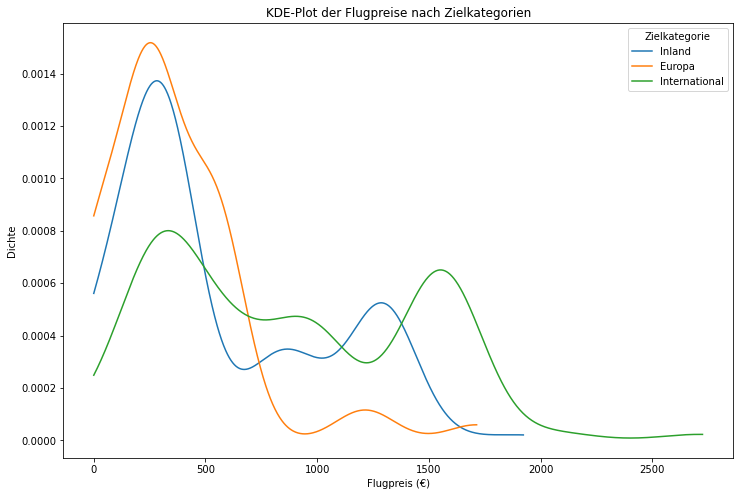

In [9]:
# Zielkategorien aus dem DataFrame
categories = df['destination_category'].unique()

# KDE-Plot für jede Zielkategorie
plt.figure(figsize=(12, 8))
for category in categories:
    subset = df[df['destination_category'] == category]['price']
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden

        plt.plot(price_range, density, label=f'{category}')

plt.title('KDE-Plot der Flugpreise nach Zielkategorien')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Zielkategorie')
plt.show()

In [10]:
# Kruskal-Wallis-Test durchführen
kruskal_stat, kruskal_p_value = stats.kruskal(
    df[df['destination_category'] == 'Inland']['price'],
    df[df['destination_category'] == 'Europa']['price'],
    df[df['destination_category'] == 'International']['price']
)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {kruskal_p_value}")

# Post-hoc Dunn-Test, wenn signifikante Unterschiede vorliegen
if kruskal_p_value < 0.05:
    print("\nSignifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.\n")
    
    # DataFrame für den Dunn-Test vorbereiten
    df_for_dunn = df[['price', 'destination_category']].copy()
    
    # Post-hoc Dunn-Test durchführen
    posthoc_dunn = sp.posthoc_dunn(df_for_dunn, val_col='price', group_col='destination_category', p_adjust='bonferroni')
    
    # Ergebnis anzeigen
    print("Post-hoc Dunn-Test Ergebnisse:\n", posthoc_dunn)
else:
    print("Keine signifikanten Unterschiede zwischen den Gruppen.")


Kruskal-Wallis-Statistik: 120.92133951773445
P-Wert: 5.524140954529801e-27

Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.

Post-hoc Dunn-Test Ergebnisse:
                      Europa        Inland  International
Europa         1.000000e+00  4.589553e-04   3.284608e-21
Inland         4.589553e-04  1.000000e+00   4.398763e-15
International  3.284608e-21  4.398763e-15   1.000000e+00


# Airline

### Airline und Flugpreise

#### Deskriptive Statistik:
Für die Analyse der Flugpreise nach Airlines haben wir ursprünglich vier Fluggesellschaften betrachtet. Da jedoch **Austrian Airlines** der österreichische Ableger von **Lufthansa** ist und somit die Flugpreise identisch sind, haben wir uns entschieden, diese Airline aus der Analyse auszuschließen, um Redundanz zu vermeiden. Daher konzentriert sich die Analyse auf drei Fluggesellschaften: **KLM**, **Lufthansa**, und **Qatar Airways**.

| Airline        | Anzahl | Durchschnittlicher Preis (€) | Standardabweichung (€) | Median (€) | Q1 (€)  | Q3 (€)  | Max (€)   |
|----------------|--------|-----------------------------|------------------------|------------|---------|---------|-----------|
| KLM            | 195    | 972.57                      | 506.31                 | 789.00     | 559.00  | 1296.00 | 2725.00   |
| Lufthansa      | 466    | 650.56                      | 536.14                 | 317.00     | 243.65  | 1019.79 | 1713.90   |
| Qatar Airways  | 128    | 422.50                      | 456.35                 | 478.50     | 1.23    | 911.00  | 1653.00   |

Die Flugpreise variieren signifikant zwischen den Airlines, was sich auch in den Mittelwerten widerspiegelt. KLM-Flüge sind im Durchschnitt teurer, während Qatar Airways tendenziell günstigere Preise aufweist.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Airlines (KLM, Lufthansa, Qatar Airways).  
**H1**: Mindestens eine Airline führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Mit dem Kruskal-Wallis-Test haben wir geprüft, ob es signifikante Unterschiede zwischen den Airlines gibt.

- **Kruskal-Wallis-Statistik**: 104.62
- **P-Wert**: 1.92e-23

Da der P-Wert extrem niedrig ist, können wir die Nullhypothese ablehnen. Dies weist darauf hin, dass die Flugpreise zwischen den Airlines signifikant unterschiedlich sind.

#### Post-hoc Dunn-Test:
Um herauszufinden, welche Airlines sich signifikant voneinander unterscheiden, haben wir den Post-hoc Dunn-Test durchgeführt.

| Vergleich        | P-Wert         | Signifikanz |
|------------------|----------------|-------------|
| KLM - Lufthansa  | 3.18e-14       | Signifikant |
| KLM - Qatar Airways | 4.50e-22    | Signifikant |
| Lufthansa - Qatar Airways | 1.77e-05 | Signifikant |

Alle drei Airlines unterscheiden sich **signifikant** voneinander, was zeigt, dass die Preisunterschiede zwischen den Airlines statistisch signifikant sind.

#### Schlussfolgerung:
Es gibt **signifikante Unterschiede** in den Flugpreisen basierend auf der Airline. KLM-Flüge sind im Durchschnitt teurer, während Qatar Airways die günstigeren Optionen anbietet. Lufthansa liegt preislich dazwischen. Diese Erkenntnisse verdeutlichen, dass die Wahl der Airline einen signifikanten Einfluss auf den Flugpreis hat, was insbesondere bei der Planung von Last-Minute-Flügen von Bedeutung ist.

In [11]:
# Berechnung der deskriptiven Statistiken für jede Airline
stats_by_airline = df.groupby('airline_name').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
).reset_index()

# Ausgabe der deskriptiven Statistiken
stats_by_airline

,airline_name,count,mean,std,min,q25,median,q75,max
0,KLM,195,972.569231,506.314151,193.0,559.000,789.0,1296.00,2725.0
1,Lufthansa,466,650.557382,536.136146,141.0,243.650,317.0,1019.79,1713.9
2,QatarAirways,128,422.496609,456.350237,0.0,1.234,478.5,911.00,1653.0


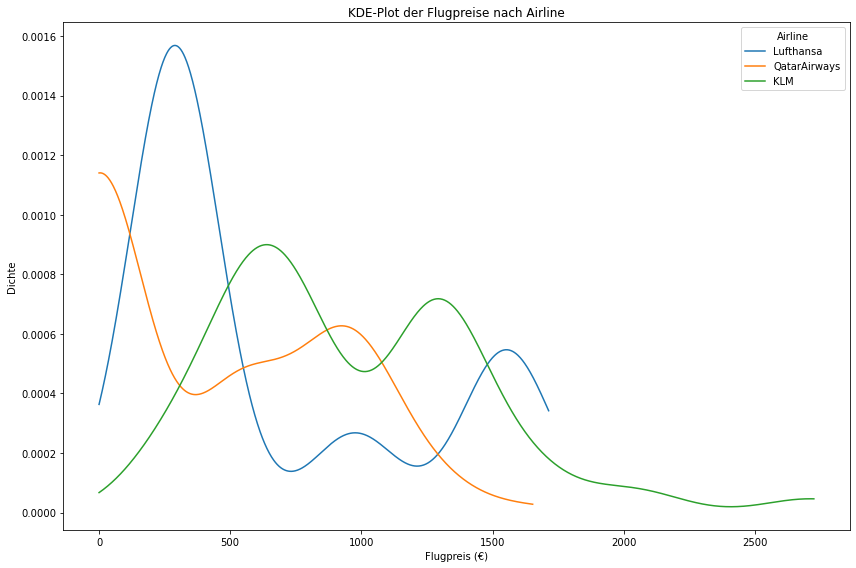

In [12]:
# Liste der Airlines
airlines = df['airline_name'].unique()

# KDE-Plot erstellen
plt.figure(figsize=(12, 8))

# KDE-Plot für jede Airline
for airline in airlines:
    subset = df[df['airline_name'] == airline]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden

        plt.plot(price_range, density, label=airline)

plt.title('KDE-Plot der Flugpreise nach Airline')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Airline')
plt.tight_layout()
plt.show()

In [13]:
# Kruskal-Wallis-Test durchführen
kruskal_stat, kruskal_p_value = stats.kruskal(
    df[df['airline_name'] == 'KLM']['price'],
    df[df['airline_name'] == 'Lufthansa']['price'],
    df[df['airline_name'] == 'QatarAirways']['price']
)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {kruskal_p_value}")

# Post-hoc Dunn-Test, wenn signifikante Unterschiede vorliegen
if kruskal_p_value < 0.05:
    print("\nSignifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.\n")
    
    # Vorbereitung der Daten für den Dunn-Test
    data_for_dunn = df[['price', 'airline_name']]
    
    # Post-hoc Dunn-Test durchführen
    posthoc_dunn = sp.posthoc_dunn(
        data_for_dunn,
        val_col='price',
        group_col='airline_name',
        p_adjust='bonferroni'
    )
    
    # Ergebnis anzeigen
    print("Post-hoc Dunn-Test Ergebnisse:\n", posthoc_dunn)
else:
    print("Keine signifikanten Unterschiede zwischen den Gruppen.")

Kruskal-Wallis-Statistik: 104.61791409662715
P-Wert: 1.9164990124488947e-23

Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.

Post-hoc Dunn-Test Ergebnisse:
                        KLM     Lufthansa  QatarAirways
KLM           1.000000e+00  3.182722e-14  4.498371e-22
Lufthansa     3.182722e-14  1.000000e+00  1.766333e-05
QatarAirways  4.498371e-22  1.766333e-05  1.000000e+00


# Transit

### Transit und Flugpreise

#### Deskriptive Statistik:
Wir haben die Transit-Dauer von Flügen in vier Kategorien eingeteilt: **kein Transit**, **kurz (0-180 Minuten)**, **mittel (181-360 Minuten)** und **lang (>360 Minuten)**. Die folgende Tabelle zeigt die deskriptive Statistik der Flugpreise für jede Transit-Gruppe:

| Transit-Gruppe          | Anzahl | Durchschnittlicher Preis (€) | Standardabweichung (€) | Median (€) | Q1 (€)  | Q3 (€)  | Max (€)   |
|-------------------------|--------|-----------------------------|------------------------|------------|---------|---------|-----------|
| kein Transit            | 376    | 463.99                      | 434.24                 | 315.98     | 243.65  | 369.00  | 1601.42   |
| kurz (0-180 Min)        | 203    | 1053.21                     | 543.53                 | 1295.00    | 659.00  | 1484.87 | 2708.00   |
| mittel (181-360 Min)    | 144    | 670.63                      | 472.85                 | 679.00     | 281.00  | 975.04  | 2059.00   |
| lang (>360 Min)         | 65     | 954.73                      | 584.51                 | 941.31     | 659.00  | 1296.00 | 2725.00   |

Hier zeigt sich, dass Flüge ohne Transit deutlich günstiger sind als solche mit Transit. Die **kurzen Transits** (0-180 Minuten) haben im Durchschnitt die höchsten Preise.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den Transit-Gruppen.  
**H1**: Mindestens eine Transit-Gruppe führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Um zu überprüfen, ob die Transit-Dauer einen signifikanten Einfluss auf den Flugpreis hat, haben wir den Kruskal-Wallis-Test verwendet.

- **Kruskal-Wallis-Statistik**: 173.15  
- **P-Wert**: 2.66e-37

Da der P-Wert extrem niedrig ist, können wir die Nullhypothese ablehnen und schließen, dass es signifikante Preisunterschiede zwischen den Transit-Gruppen gibt.

#### Post-hoc Dunn-Test:
Um zu erkennen, welche Transit-Gruppen sich signifikant voneinander unterscheiden, haben wir den Post-hoc Dunn-Test durchgeführt.

| Vergleich             | P-Wert         | Signifikanz |
|-----------------------|----------------|-------------|
| kein Transit - kurz   | 2.03e-32       | Signifikant |
| kein Transit - mittel | 4.21e-07       | Signifikant |
| kein Transit - lang   | 1.58e-11       | Signifikant |
| kurz - mittel         | 6.94e-10       | Signifikant |
| kurz - lang           | 6.60e-01       | Nicht signifikant |
| mittel - lang         | 1.51e-02       | Signifikant |

Da **kurze** (0-180 Minuten) und **lange** (>360 Minuten) Transits keine signifikanten Unterschiede aufweisen, haben wir diese beiden Kategorien zur Gruppe **"kurz & lang"** zusammengefasst.

#### Neugruppierung der Transit-Gruppen:

| Ursprüngliche Gruppe       | Neue Gruppe                            |
|----------------------------|----------------------------------------|
| kurz (0-180 Min)            | kurz & lang (0-180 Min und >360 Min)   |
| lang (>360 Min)             | kurz & lang (0-180 Min und >360 Min)   |
| mittel (181-360 Min)        | mittel (181-360 Min)                   |
| kein Transit                | kein Transit                           |

#### Schlussfolgerung:
Die Transit-Dauer hat einen signifikanten Einfluss auf den Flugpreis. Insbesondere Flüge mit **kurzem** oder **langem Transit** weisen ähnliche Preise auf und sind tendenziell teurer als Flüge ohne Transit. Die **mittleren Transitzeiten** (181-360 Minuten) zeigen einen signifikanten Unterschied sowohl zu den kurzen als auch zu den langen Transits, was die Kategorisierung unterstützt.


In [14]:
# Konvertiere die 'transit_duration' in Minuten
def convert_to_minutes(time_str):
    try:
        h, m = map(int, time_str.split(':'))
        return h * 60 + m
    except:
        return np.nan

df['transit_duration_minutes'] = df['transit_duration'].apply(convert_to_minutes)

# Einteilung der Transit-Dauer in Gruppen
df['transit_group'] = pd.cut(
    df['transit_duration_minutes'], 
    bins=[-0.1, 0.1, 180, 360, float('inf')], 
    labels=['kein Transit', 'kurz (0-180 Min)', 'mittel (181-360 Min)', 'lang (>360 Min)']
)

# Berechnung der deskriptiven Statistiken basierend auf der Transit-Dauer-Gruppe
transit_stats = df.groupby('transit_group').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
)

# Ausgabe der deskriptiven Statistik
transit_stats

,count,mean,std,min,q25,median,q75,max
transit_group,,,,,,,,
kein Transit,376,463.993662,434.237523,0.000,243.65,315.98,369.00,1601.42
kurz (0-180 Min),203,1053.205882,543.531879,1.009,659.00,1295.00,1484.87,2708.00
mittel (181-360 Min),144,670.626035,472.846027,1.008,281.00,679.00,975.04,2059.00
lang (>360 Min),65,954.734554,584.509081,1.043,659.00,941.31,1296.00,2725.00


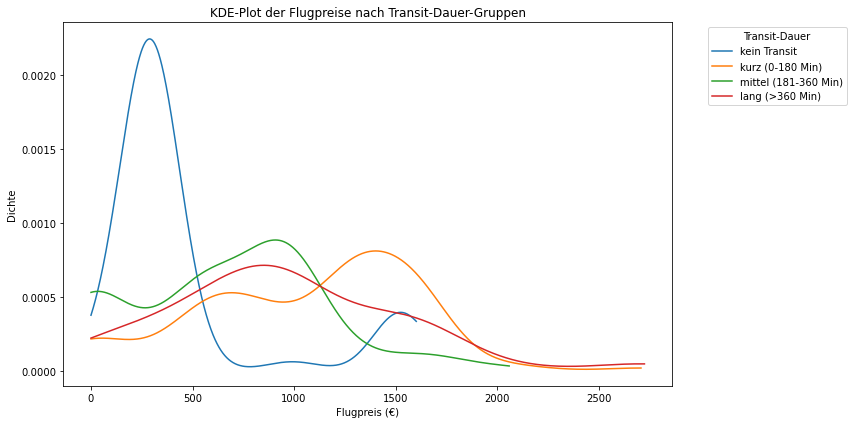

In [15]:
# Daten filtern: Entfernen von NaN-Werten in 'price' und 'transit_group'
df = df.dropna(subset=['price', 'transit_group'])

# KDE-Plot erstellen
plt.figure(figsize=(12, 6))

# KDE-Plot für jede Transit-Gruppe
for group in df['transit_group'].unique():
    subset = df[df['transit_group'] == group]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=group)

plt.title('KDE-Plot der Flugpreise nach Transit-Dauer-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Transit-Dauer', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legende nach rechts verschieben
plt.tight_layout()  
plt.show()

In [16]:
# Vorbereitung der Daten: Entfernen von NaN-Werten in 'price' und 'transit_group'
df = df.dropna(subset=['price', 'transit_group'])

# Erstellen von Listen für jede Transit-Gruppe
prices_kein_transit = df[df['transit_group'] == 'kein Transit']['price']
prices_kurz = df[df['transit_group'] == 'kurz (0-180 Min)']['price']
prices_mittel = df[df['transit_group'] == 'mittel (181-360 Min)']['price']
prices_lang = df[df['transit_group'] == 'lang (>360 Min)']['price']

# Durchführung des Kruskal-Wallis-Tests
kruskal_result = stats.kruskal(prices_kein_transit, prices_kurz, prices_mittel, prices_lang)

# Ausgabe der Ergebnisse
print(f"Kruskal-Wallis-Statistik: {kruskal_result.statistic}")
print(f"P-Wert: {kruskal_result.pvalue}")

Kruskal-Wallis-Statistik: 173.15005064205994
P-Wert: 2.658168011800809e-37


In [17]:
# Paarweise Gruppen vergleichen
groups = df['transit_group'].unique()
p_values = []

for (group1, group2) in itertools.combinations(groups, 2):
    data1 = df[df['transit_group'] == group1]['price']
    data2 = df[df['transit_group'] == group2]['price']
    
    # Mann-Whitney-U-Test
    stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    p_values.append((group1, group2, p))

# Bonferroni-Korrektur
p_values_df = pd.DataFrame(p_values, columns=['Group1', 'Group2', 'p_value'])
p_values_df['adjusted_p_value'] = p_values_df['p_value'] * len(p_values)

# Ergebnis anzeigen
p_values_df['significant'] = p_values_df['adjusted_p_value'] < 0.05
p_values_df

,Group1,Group2,p_value,adjusted_p_value,significant
0,kein Transit,kurz (0-180 Min),3.380817e-33,2.028490e-32,True
1,kein Transit,mittel (181-360 Min),7.018483e-08,4.211090e-07,True
2,kein Transit,lang (>360 Min),2.640049e-12,1.584029e-11,True
3,kurz (0-180 Min),mittel (181-360 Min),1.156908e-10,6.941450e-10,True
4,kurz (0-180 Min),lang (>360 Min),1.099265e-01,6.595589e-01,False
5,mittel (181-360 Min),lang (>360 Min),2.509942e-03,1.505965e-02,True


In [18]:
# Neugruppierung der Transit-Dauer
df['transit_group_simplified'] = df['transit_group'].replace({
    'kurz (0-180 Min)': 'kurz & lang (0-180 Min und >360 Min)',
    'lang (>360 Min)': 'kurz & lang (0-180 Min und >360 Min)'
})

# Überprüfen der neuen Gruppierungen
print(df['transit_group_simplified'].value_counts())

# Kruskal-Wallis-Test mit den neuen Kategorien
df = df.dropna(subset=['price', 'transit_group_simplified'])
prices_keine = df[df['transit_group_simplified'] == 'kein Transit']['price']
prices_kurz_lang = df[df['transit_group_simplified'] == 'kurz & lang (0-180 Min und >360 Min)']['price']
prices_mittel = df[df['transit_group_simplified'] == 'mittel (181-360 Min)']['price']

kruskal_result_simplified = stats.kruskal(prices_keine, prices_kurz_lang, prices_mittel)
print(f"Kruskal-Wallis-Statistik: {kruskal_result_simplified.statistic}")
print(f"P-Wert: {kruskal_result_simplified.pvalue}")

# Falls signifikant, führe Post-hoc-Tests durch
if kruskal_result_simplified.pvalue < 0.05:
    posthoc_results_simplified = sp.posthoc_dunn(
        df, val_col='price', group_col='transit_group_simplified', p_adjust='bonferroni'
    )
    print("\nPost-hoc Dunn-Test Ergebnisse (vereinfachte Gruppen):")
    print(posthoc_results_simplified)

kein Transit                            376
kurz & lang (0-180 Min und >360 Min)    268
mittel (181-360 Min)                    144
Name: transit_group_simplified, dtype: int64
Kruskal-Wallis-Statistik: 171.6567489647901
P-Wert: 5.311419107218657e-38

Post-hoc Dunn-Test Ergebnisse (vereinfachte Gruppen):
                                      kein Transit  \
kein Transit                          1.000000e+00   
kurz & lang (0-180 Min und >360 Min)  1.065885e-38   
mittel (181-360 Min)                  3.455149e-06   

                                      kurz & lang (0-180 Min und >360 Min)  \
kein Transit                                                  1.065885e-38   
kurz & lang (0-180 Min und >360 Min)                          1.000000e+00   
mittel (181-360 Min)                                          1.028397e-07   

                                      mittel (181-360 Min)  
kein Transit                                  3.455149e-06  
kurz & lang (0-180 Min und >360 Min)      

# Ankunft

### Ankunftszeit und Flugpreise

#### Deskriptive Statistik:
Die Flugpreise wurden in vier Gruppen basierend auf der Ankunftszeit unterteilt: **Morgen**, **Mittag/Nachmittag**, **Abend** und **Nacht**. Die Tabelle unten zeigt die deskriptiven Statistiken der Flugpreise für jede Ankunftszeit-Gruppe:

| Ankunftszeit-Gruppe   | Anzahl | Durchschnittlicher Preis (€) | Standardabweichung (€) | Median (€) | Q1 (€)  | Q3 (€)  | Max (€)   |
|-----------------------|--------|-----------------------------|------------------------|------------|---------|---------|-----------|
| Abend                 | 206    | 807.35                      | 531.92                 | 723.50     | 313.08  | 1009.92 | 2725.00   |
| Mittag/Nachmittag     | 318    | 644.22                      | 538.41                 | 369.00     | 281.00  | 1004.75 | 1923.00   |
| Morgen                | 248    | 676.14                      | 559.98                 | 453.84     | 235.62  | 1295.00 | 1530.17   |
| Nacht                 | 16     | 502.07                      | 472.92                 | 648.50     | 1.03    | 966.00  | 996.00    |

Hier zeigt sich, dass die **Abendflüge** im Durchschnitt die höchsten Preise aufweisen, während **Nachtflüge** am günstigsten sind, jedoch mit einer sehr kleinen Stichprobe.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den Ankunftszeit-Gruppen.  
**H1**: Mindestens eine Ankunftszeit-Gruppe führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Um die Preisunterschiede zwischen den Ankunftszeiten zu analysieren, haben wir den Kruskal-Wallis-Test verwendet.

- **Kruskal-Wallis-Statistik**: 20.94  
- **P-Wert**: 0.00011

Da der P-Wert kleiner als 0.05 ist, lehnen wir die Nullhypothese ab und schließen, dass es signifikante Preisunterschiede zwischen den Gruppen gibt.

#### Post-hoc Dunn-Test:
Um die genauen Unterschiede zwischen den Ankunftszeit-Gruppen zu untersuchen, haben wir den Post-hoc Dunn-Test durchgeführt:

| Vergleich             | P-Wert         | Signifikanz |
|-----------------------|----------------|-------------|
| Abend - Mittag/Nachmittag | 0.0066       | Signifikant |
| Abend - Morgen            | 0.0002       | Signifikant |
| Abend - Nacht             | 0.0595       | Nicht signifikant |
| Mittag/Nachmittag - Morgen | 1.0000      | Nicht signifikant |
| Mittag/Nachmittag - Nacht  | 0.8445      | Nicht signifikant |
| Morgen - Nacht            | 1.0000      | Nicht signifikant |

Es zeigt sich, dass **Abendflüge** signifikant teurer sind als **Mittag/Nachmittags**- und **Morgenflüge**. Flüge am **Abend** und **Nachtflüge** unterscheiden sich jedoch nicht signifikant voneinander.

#### Neugruppierung der Ankunftszeit-Gruppen:

Basierend auf den Ergebnissen des Dunn-Tests haben wir die Ankunftszeit-Gruppen folgendermaßen neu kategorisiert:

| Ursprüngliche Gruppe   | Neue Gruppe   |
|------------------------|---------------|
| Mittag/Nachmittag       | Rest          |
| Morgen                  | Rest          |
| Nacht                   | Rest          |
| Abend                   | Abend         |

#### Schlussfolgerung:
Die Ankunftszeit hat einen signifikanten Einfluss auf den Flugpreis. Insbesondere **Abendflüge** sind im Vergleich zu anderen Zeitpunkten tendenziell teurer. Da **Mittag/Nachmittag**, **Morgen** und **Nachtflüge** keine signifikanten Unterschiede zeigen, wurden diese zur Gruppe **"Rest"** zusammengefasst.


In [19]:
# Funktion zur Konvertierung von Ankunftszeiten in Minuten seit Mitternacht
def convert_to_minutes(time_str):
    try:
        h, m = map(int, time_str.split(':'))
        return h * 60 + m
    except ValueError:
        return None

# Ankunftszeiten in Minuten umwandeln, ungültige Werte droppen
df['arrival_time_minutes'] = df['arrival_time'].apply(convert_to_minutes)
df = df.dropna(subset=['arrival_time_minutes'])

# Einteilung der Ankunftszeiten in Zeitgruppen
def categorize_time(minutes):
    if 360 <= minutes <= 719:  # 06:00 - 11:59
        return 'Morgen'
    elif 720 <= minutes <= 1079:  # 12:00 - 17:59
        return 'Mittag/Nachmittag'
    elif 1080 <= minutes <= 1439:  # 18:00 - 23:59
        return 'Abend'
    else:  # 00:00 - 05:59
        return 'Nacht'

df['arrival_time_group'] = df['arrival_time_minutes'].apply(categorize_time)

# Deskriptive Statistiken der Preise nach Ankunftszeit-Gruppen
price_group_stats = df.groupby('arrival_time_group').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
)

# Ausgabe der deskriptiven Statistik
price_group_stats

,count,mean,std,min,q25,median,q75,max
arrival_time_group,,,,,,,,
Abend,206,807.349417,531.915081,177.600,313.080,723.50,1009.9225,2725.00
Mittag/Nachmittag,318,644.216459,538.408698,1.008,281.000,369.00,1004.7500,1923.00
Morgen,248,676.138560,559.982384,1.043,235.615,453.84,1295.0000,1530.17
Nacht,16,502.070562,472.917164,0.000,1.030,648.50,966.0000,996.00


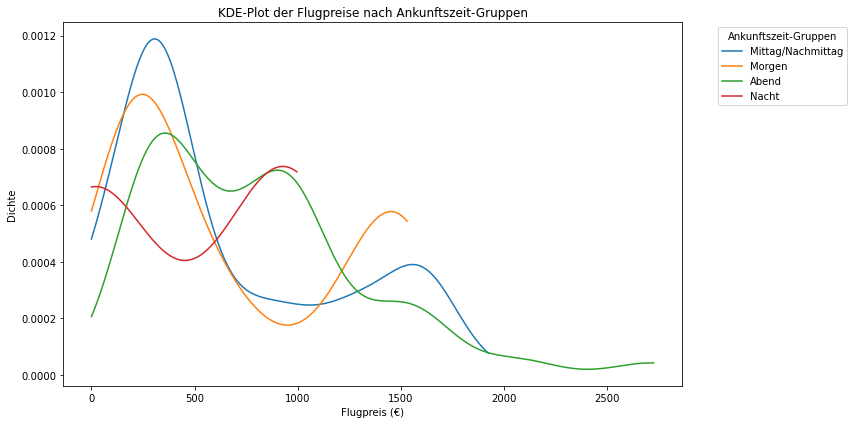

In [20]:
# KDE-Plot erstellen
plt.figure(figsize=(12, 6))

# KDE-Plot für jede Ankunftszeit-Gruppe
for group in df['arrival_time_group'].unique():
    subset = df[df['arrival_time_group'] == group]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=group)

plt.title('KDE-Plot der Flugpreise nach Ankunftszeit-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Ankunftszeit-Gruppen', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legende nach rechts verschieben
plt.tight_layout()
plt.show()

In [21]:
# Durchführung des Kruskal-Wallis-Tests
groups = [df[df['arrival_time_group'] == group]['price'] for group in df['arrival_time_group'].unique()]
kruskal_stat, kruskal_p_value = kruskal(*groups)

print(f"\nKruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {kruskal_p_value}")

# Wenn signifikante Unterschiede gefunden wurden, dann führe den Post-hoc Dunn-Test durch
if kruskal_p_value < 0.05:
    print("\nSignifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.")
    posthoc_results = sp.posthoc_dunn(df, val_col='price', group_col='arrival_time_group', p_adjust='bonferroni')
    print("\nPost-hoc Dunn-Test Ergebnisse:")
    print(posthoc_results)
else:
    print("\nKeine signifikanten Unterschiede zwischen den Gruppen. Ein Post-hoc-Test ist nicht erforderlich.")



Kruskal-Wallis-Statistik: 20.937492158212763
P-Wert: 0.00010847022943579631

Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.

Post-hoc Dunn-Test Ergebnisse:
                      Abend  Mittag/Nachmittag    Morgen     Nacht
Abend              1.000000           0.006596  0.000235  0.059461
Mittag/Nachmittag  0.006596           1.000000  1.000000  0.844484
Morgen             0.000235           1.000000  1.000000  1.000000
Nacht              0.059461           0.844484  1.000000  1.000000


                               count        mean         std    min     q25  \
arrival_time_group_simplified                                                 
Abend                            206  807.349417  531.915081  177.6  313.08   
Rest                             582  653.911213  546.028683    0.0  243.65   

                               median        q75     max  
arrival_time_group_simplified                             
Abend                           723.5  1009.9225  2725.0  
Rest                            369.0  1280.5000  1923.0  


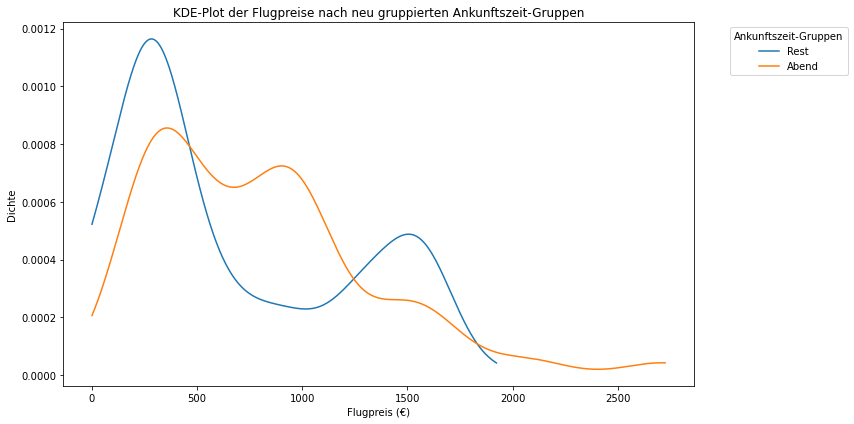


Kruskal-Wallis-Statistik (vereinfacht): 17.908824023117706
P-Wert (vereinfacht): 2.3174413959580284e-05

Signifikante Unterschiede zwischen den neu gruppierten Gruppen nachgewiesen.


In [22]:
# Neu-Gruppierung der Ankunftszeit-Gruppen basierend auf den Dunn-Test-Ergebnissen
df['arrival_time_group_simplified'] = df['arrival_time_group'].replace({
    'Mittag/Nachmittag': 'Rest',
    'Morgen': 'Rest',
    'Nacht': 'Rest'
})

# Deskriptive Statistiken der Preise nach neu gruppierten Ankunftszeit-Gruppen
price_group_stats_simplified = df.groupby('arrival_time_group_simplified').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
)

# Ausgabe der deskriptiven Statistik
print(price_group_stats_simplified)

# KDE-Plot für die neu gruppierten Ankunftszeit-Gruppen
plt.figure(figsize=(12, 6))

for group in df['arrival_time_group_simplified'].unique():
    subset = df[df['arrival_time_group_simplified'] == group]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=group)

plt.title('KDE-Plot der Flugpreise nach neu gruppierten Ankunftszeit-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Ankunftszeit-Gruppen', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legende nach rechts verschieben
plt.tight_layout()
plt.show()

# Durchführung des Kruskal-Wallis-Tests für die neu gruppierten Ankunftszeit-Gruppen
groups_simplified = [df[df['arrival_time_group_simplified'] == group]['price'] for group in df['arrival_time_group_simplified'].unique()]
kruskal_stat_simplified, kruskal_p_value_simplified = kruskal(*groups_simplified)

print(f"\nKruskal-Wallis-Statistik (vereinfacht): {kruskal_stat_simplified}")
print(f"P-Wert (vereinfacht): {kruskal_p_value_simplified}")

# Überprüfen, ob signifikante Unterschiede bestehen
if kruskal_p_value_simplified < 0.05:
    print("\nSignifikante Unterschiede zwischen den neu gruppierten Gruppen nachgewiesen.")
else:
    print("\nKeine signifikanten Unterschiede zwischen den neu gruppierten Gruppen.")

# Abflug

### Abflugzeit und Flugpreise

#### Deskriptive Statistik:
Die Flugpreise wurden in vier Gruppen basierend auf der Abflugzeit unterteilt: **Morgen**, **Mittag/Nachmittag**, **Abend** und **Nacht**. Die Tabelle unten zeigt die deskriptiven Statistiken der Flugpreise für jede Abflugzeit-Gruppe:

| Abflugzeit-Gruppe   | Anzahl | Durchschnittlicher Preis (€) | Standardabweichung (€) | Median (€) | Q1 (€)  | Q3 (€)  | Max (€)   |
|---------------------|--------|-----------------------------|------------------------|------------|---------|---------|-----------|
| Abend               | 182    | 555.13                      | 501.46                 | 315.04     | 273.52  | 927.25  | 2725.00   |
| Mittag/Nachmittag   | 244    | 837.75                      | 569.80                 | 789.00     | 363.66  | 1387.58 | 2708.00   |
| Morgen              | 346    | 685.03                      | 535.29                 | 333.60     | 243.65  | 1020.07 | 2098.00   |
| Nacht               | 16     | 276.48                      | 107.93                 | 315.98     | 315.98  | 315.98  | 315.98    |

**Mittag/Nachmittag**-Flüge weisen im Durchschnitt die höchsten Preise auf, während **Nachtflüge** die günstigsten, aber auch die am wenigsten frequentierten sind.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den Abflugzeit-Gruppen.  
**H1**: Mindestens eine Abflugzeit-Gruppe führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Zur Überprüfung der Preisunterschiede zwischen den Abflugzeiten haben wir den Kruskal-Wallis-Test durchgeführt.

- **Kruskal-Wallis-Statistik**: 41.44  
- **P-Wert**: 5.28e-09

Da der P-Wert deutlich kleiner als 0.05 ist, können wir die Nullhypothese ablehnen und davon ausgehen, dass es signifikante Unterschiede zwischen den Gruppen gibt.

#### Post-hoc Dunn-Test:
Um festzustellen, welche Abflugzeit-Gruppen sich signifikant unterscheiden, wurde der Dunn-Test durchgeführt:

| Vergleich             | P-Wert         | Signifikanz |
|-----------------------|----------------|-------------|
| Morgen - Mittag/Nachmittag  | 0.000539       | Signifikant |
| Morgen - Abend              | 0.0554         | Nicht signifikant |
| Morgen - Nacht              | 0.1080         | Nicht signifikant |
| Mittag/Nachmittag - Abend   | 4.57e-08       | Signifikant |
| Mittag/Nachmittag - Nacht   | 0.0018         | Signifikant |
| Abend - Nacht               | 0.9587         | Nicht signifikant |

Es zeigte sich, dass **Mittag/Nachmittagsflüge** signifikant teurer sind als **Morgen-** und **Abendflüge**. **Nachtflüge** und **Abendflüge** sowie **Morgenflüge** unterscheiden sich hingegen nicht signifikant.

#### Neugruppierung der Abflugzeit-Gruppen:
Basierend auf den Ergebnissen des Dunn-Tests haben wir die Abflugzeit-Gruppen folgendermaßen vereinfacht:

| Ursprüngliche Gruppe  | Neue Gruppe          |
|-----------------------|----------------------|
| Mittag/Nachmittag      | Mittag/Nachmittag    |
| Morgen                 | Rest                 |
| Abend                  | Rest                 |
| Nacht                  | Rest                 |

#### Schlussfolgerung:
Die Abflugzeit wirkt sich signifikant auf den Flugpreis aus, insbesondere sind **Mittag/Nachmittagsflüge** die teuersten. **Morgen-, Abend-** und **Nachtflüge** zeigen keine signifikanten Unterschiede und wurden daher in die Gruppe **"Rest"** zusammengefasst.


In [23]:
# Funktion zur Konvertierung von Abflugzeiten in Minuten seit Mitternacht
def convert_to_minutes(time_str):
    try:
        h, m = map(int, time_str.split(':'))
        return h * 60 + m
    except ValueError:
        return None

# Abflugzeiten in Minuten umwandeln, ungültige Werte droppen
df['departure_time_minutes'] = df['departure_time'].apply(convert_to_minutes)
df = df.dropna(subset=['departure_time_minutes'])

# Einteilung der Abflugzeiten in Zeitgruppen
def categorize_time(minutes):
    if 360 <= minutes <= 719:  # 06:00 - 11:59
        return 'Morgen'
    elif 720 <= minutes <= 1079:  # 12:00 - 17:59
        return 'Mittag/Nachmittag'
    elif 1080 <= minutes <= 1439:  # 18:00 - 23:59
        return 'Abend'
    else:  # 00:00 - 05:59
        return 'Nacht'

df['departure_time_group'] = df['departure_time_minutes'].apply(categorize_time)

# Deskriptive Statistiken der Abflugzeiten-Gruppen basierend auf dem Preis
departure_group_stats = df.groupby('departure_time_group').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
)

# Ausgabe der deskriptiven Statistik
departure_group_stats

,count,mean,std,min,q25,median,q75,max
departure_time_group,,,,,,,,
Abend,182,555.133709,501.459285,1.008,273.5200,315.04,927.25,2725.00
Mittag/Nachmittag,244,837.754307,569.799925,1.009,363.6625,789.00,1387.58,2708.00
Morgen,346,685.029480,535.286842,141.000,243.6500,333.60,1020.07,2098.00
Nacht,16,276.482500,107.927717,0.000,315.9800,315.98,315.98,315.98


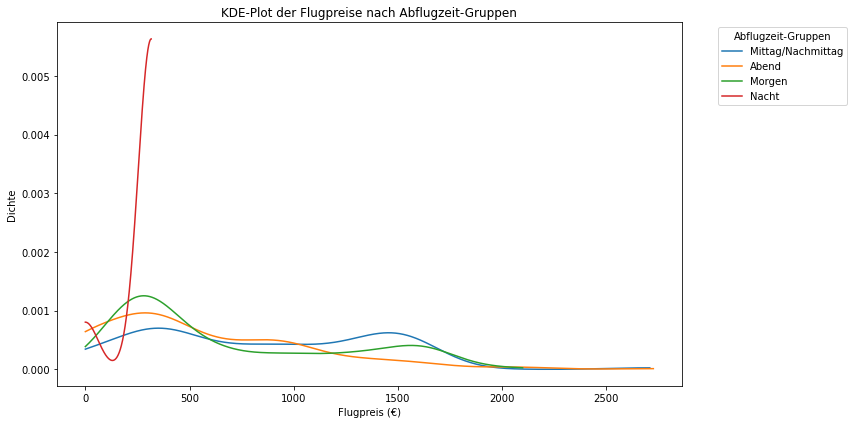

In [24]:
# KDE-Plot erstellen
plt.figure(figsize=(12, 6))

# KDE-Plot für jede Abflugzeit-Gruppe
for group in df['departure_time_group'].unique():
    subset = df[df['departure_time_group'] == group]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=group)

plt.title('KDE-Plot der Flugpreise nach Abflugzeit-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Abflugzeit-Gruppen', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legende nach rechts verschieben
plt.tight_layout()  
plt.show()


In [25]:
# Kruskal-Wallis-Test
kw_stat, kw_p_value = stats.kruskal(
    df[df['departure_time_group'] == 'Morgen']['price'],
    df[df['departure_time_group'] == 'Mittag/Nachmittag']['price'],
    df[df['departure_time_group'] == 'Abend']['price'],
    df[df['departure_time_group'] == 'Nacht']['price']
)

print(f"Kruskal-Wallis-Statistik: {kw_stat}")
print(f"P-Wert: {kw_p_value}")

# Wenn der Kruskal-Wallis-Test signifikante Unterschiede zeigt, wird ein Post-hoc Dunn-Test durchgeführt
if kw_p_value < 0.05:
    print("\nSignifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.\n")
    
    # Post-hoc Dunn-Test
    dunn_test_results = sp.posthoc_dunn(
        [df[df['departure_time_group'] == group]['price'] for group in ['Morgen', 'Mittag/Nachmittag', 'Abend', 'Nacht']], 
        p_adjust='bonferroni'
    )
    
    # Formatieren und Anzeigen der Ergebnisse
    dunn_test_results.columns = ['Morgen', 'Mittag/Nachmittag', 'Abend', 'Nacht']
    dunn_test_results.index = ['Morgen', 'Mittag/Nachmittag', 'Abend', 'Nacht']
    print("Post-hoc Dunn-Test Ergebnisse:")
    print(dunn_test_results)
else:
    print("\nKeine signifikanten Unterschiede zwischen den Abflugzeit-Gruppen nachgewiesen.")

Kruskal-Wallis-Statistik: 41.439487913196665
P-Wert: 5.275960741104513e-09

Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.

Post-hoc Dunn-Test Ergebnisse:
                     Morgen  Mittag/Nachmittag         Abend     Nacht
Morgen             1.000000       5.386660e-04  5.544440e-02  0.107999
Mittag/Nachmittag  0.000539       1.000000e+00  4.573928e-08  0.001817
Abend              0.055444       4.573928e-08  1.000000e+00  0.958704
Nacht              0.107999       1.817268e-03  9.587040e-01  1.000000


                                 count        mean         std    min  \
departure_time_group_simplified                                         
Mittag/Nachmittag                  244  837.754307  569.799925  1.009   
Rest                               544  629.555616  523.147692  0.000   

                                      q25  median      q75     max  
departure_time_group_simplified                                     
Mittag/Nachmittag                363.6625   789.0  1387.58  2708.0  
Rest                             243.6500   333.6   966.12  2725.0  


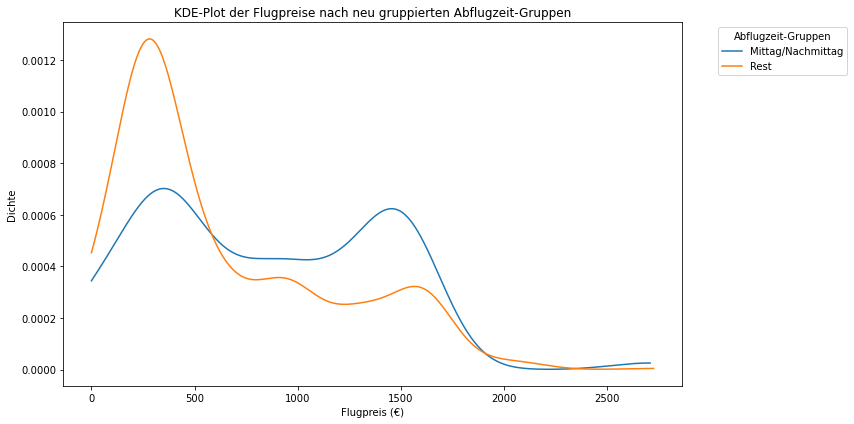


Kruskal-Wallis-Statistik (vereinfacht): 30.419847395218184
P-Wert (vereinfacht): 3.4794985734936045e-08

Signifikante Unterschiede zwischen den neu gruppierten Gruppen nachgewiesen.


In [26]:
# Neu-Gruppierung der Abflugzeit-Gruppen basierend auf den Dunn-Test-Ergebnissen
df['departure_time_group_simplified'] = df['departure_time_group'].replace({
    'Mittag/Nachmittag': 'Mittag/Nachmittag',
    'Morgen': 'Rest',
    'Abend': 'Rest',
    'Nacht': 'Rest'
})

# Deskriptive Statistiken der Preise nach neu gruppierten Abflugzeit-Gruppen
departure_group_stats_simplified = df.groupby('departure_time_group_simplified').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
)

# Ausgabe der deskriptiven Statistik
print(departure_group_stats_simplified)

# KDE-Plot für die neu gruppierten Abflugzeit-Gruppen
plt.figure(figsize=(12, 6))

for group in df['departure_time_group_simplified'].unique():
    subset = df[df['departure_time_group_simplified'] == group]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=group)

plt.title('KDE-Plot der Flugpreise nach neu gruppierten Abflugzeit-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Abflugzeit-Gruppen', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legende nach rechts verschieben
plt.tight_layout()
plt.show()

# Durchführung des Kruskal-Wallis-Tests für die neu gruppierten Abflugzeit-Gruppen
groups_simplified = [df[df['departure_time_group_simplified'] == group]['price'] for group in df['departure_time_group_simplified'].unique()]
kruskal_stat_simplified, kruskal_p_value_simplified = kruskal(*groups_simplified)

print(f"\nKruskal-Wallis-Statistik (vereinfacht): {kruskal_stat_simplified}")
print(f"P-Wert (vereinfacht): {kruskal_p_value_simplified}")

# Überprüfen, ob signifikante Unterschiede bestehen
if kruskal_p_value_simplified < 0.05:
    print("\nSignifikante Unterschiede zwischen den neu gruppierten Gruppen nachgewiesen.")
else:
    print("\nKeine signifikanten Unterschiede zwischen den neu gruppierten Gruppen.")


# Reisedauer

### Reisedauer und Flugpreise

#### Deskriptive Statistik:
Die Reisedauer wurde in drei Gruppen unterteilt: **kurz (0-180 Min)**, **mittel (181-360 Min)** und **lang (>360 Min)**. Die Tabelle zeigt die deskriptiven Statistiken der Flugpreise für jede Gruppe basierend auf der Reisedauer:

| Reisedauer-Gruppe   | Anzahl | Durchschnittlicher Preis (€) | Standardabweichung (€) | Median (€) | Q1 (€) | Q3 (€) | Max (€)  |
|---------------------|--------|-----------------------------|------------------------|------------|--------|--------|----------|
| kurz (0-180 Min)     | 312    | 96.92                       | 44.46                  | 70.00      | 65.00  | 126.25 | 180      |
| mittel (181-360 Min) | 95     | 259.42                      | 40.81                  | 265.00     | 215.00 | 285.00 | 355      |
| lang (>360 Min)      | 381    | 822.11                      | 330.94                 | 735.00     | 655.00 | 880.00 | 2120     |

Es zeigt sich, dass **kurze Flüge** deutlich günstiger sind, während **lange Flüge** im Durchschnitt den höchsten Preis haben.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den Reisedauer-Gruppen.  
**H1**: Mindestens eine Reisedauer-Gruppe führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Zur Untersuchung der Preisunterschiede zwischen den Reisedauer-Gruppen wurde der Kruskal-Wallis-Test durchgeführt.

- **Kruskal-Wallis-Statistik**: 284.54  
- **P-Wert**: 1.64e-62

Der extrem niedrige P-Wert zeigt, dass wir die Nullhypothese ablehnen können, was bedeutet, dass signifikante Unterschiede zwischen den Gruppen bestehen.

#### Post-hoc Dunn-Test:
Zur genaueren Untersuchung, welche Gruppen sich signifikant unterscheiden, wurde der Dunn-Test durchgeführt:

| Vergleich  | P-Wert         | Signifikanz |
|------------|----------------|-------------|
| kurz - lang   | 1.66e-53       | Signifikant |
| kurz - mittel | 9.23e-32       | Signifikant |
| lang - mittel | 0.2262         | Nicht signifikant |

Es zeigte sich, dass **kurze Flüge** sowohl gegenüber **langen** als auch **mittleren Flügen** signifikant günstigere Preise aufweisen. Zwischen **langen** und **mittleren Flügen** gab es jedoch keinen signifikanten Preisunterschied.

#### Neugruppierung der Reisedauer-Gruppen:
Auf Basis der Dunn-Test-Ergebnisse haben wir die Reisedauer-Gruppen vereinfacht, indem **lange** und **mittlere Flüge** in eine gemeinsame Gruppe zusammengefasst wurden, da sie sich nicht signifikant unterscheiden:

| Ursprüngliche Gruppe  | Neue Gruppe    |
|-----------------------|----------------|
| lang                  | mittel/lang    |
| mittel                | mittel/lang    |
| kurz                  | kurz           |

#### Schlussfolgerung:
Die Reisedauer beeinflusst die Flugpreise signifikant, insbesondere sind **kurze Flüge** am günstigsten. Da **mittlere** und **lange Flüge** keine signifikanten Unterschiede aufweisen, wurden diese beiden Gruppen zusammengefasst.

In [27]:
# Funktion zur Konvertierung von Reisedauer in Minuten
def convert_to_minutes(duration_str):
    try:
        h, m = map(int, duration_str.split(':'))
        return h * 60 + m
    except ValueError:
        return np.nan

# Reisedauer in Minuten umwandeln, ungültige Werte droppen
df['travel_duration_minutes'] = df['travel_duration'].apply(convert_to_minutes)
df = df.dropna(subset=['travel_duration_minutes'])

# Einteilung der Reisedauer in Zeitgruppen (beispielhafte Kategorien)
def categorize_duration(minutes):
    if minutes <= 180:  # bis 3 Stunden
        return 'kurz'
    elif 180 < minutes <= 360:  # 3 bis 6 Stunden
        return 'mittel'
    else:  # länger als 6 Stunden
        return 'lang'

df['travel_duration_group'] = df['travel_duration_minutes'].apply(categorize_duration)

# Deskriptive Statistiken der Reisedauer-Gruppen
duration_group_stats = df.groupby('travel_duration_group').agg(
    count=('travel_duration_minutes', 'count'),
    mean=('travel_duration_minutes', 'mean'),
    std=('travel_duration_minutes', 'std'),
    min=('travel_duration_minutes', 'min'),
    q25=('travel_duration_minutes', lambda x: x.quantile(0.25)),
    median=('travel_duration_minutes', 'median'),
    q75=('travel_duration_minutes', lambda x: x.quantile(0.75)),
    max=('travel_duration_minutes', 'max')
)

# Ausgabe der deskriptiven Statistik
duration_group_stats

,count,mean,std,min,q25,median,q75,max
travel_duration_group,,,,,,,,
kurz,312,96.923077,44.459822,0,65.0,70.0,126.25,180
lang,381,822.112861,330.941337,365,655.0,735.0,880.00,2120
mittel,95,259.421053,40.808734,195,215.0,265.0,285.00,355


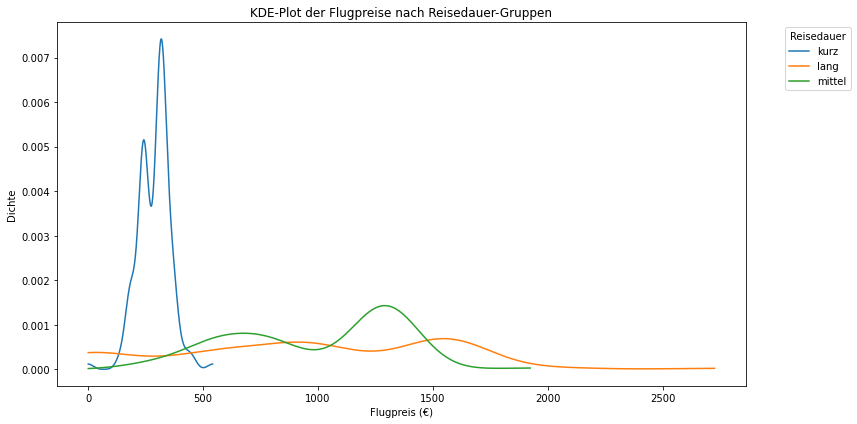

In [28]:
# KDE-Plot erstellen
plt.figure(figsize=(12, 6))

# KDE-Plot für jede Reisedauer-Gruppe
for group in df['travel_duration_group'].unique():
    subset = df[df['travel_duration_group'] == group]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=group)

plt.title('KDE-Plot der Flugpreise nach Reisedauer-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Reisedauer', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legende nach rechts verschieben
plt.tight_layout()  
plt.show()

In [29]:
# Kruskal-Wallis-Test durchführen
kruskal_stat, kruskal_p_value = stats.kruskal(
    df[df['travel_duration_group'] == 'kurz']['price'],
    df[df['travel_duration_group'] == 'mittel']['price'],
    df[df['travel_duration_group'] == 'lang']['price']
)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {kruskal_p_value}")

# Post-hoc Dunn-Test, wenn signifikante Unterschiede vorliegen
if kruskal_p_value < 0.05:
    print("\nSignifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.\n")
    
    # Daten für den Dunn-Test vorbereiten
    df_for_dunn = df[['price', 'travel_duration_group']]
    df_for_dunn.dropna(inplace=True)
    
    # Post-hoc Dunn-Test durchführen
    posthoc_dunn = sp.posthoc_dunn(df_for_dunn, val_col='price', group_col='travel_duration_group', p_adjust='bonferroni')
    
    # Ergebnis anzeigen
    print("Post-hoc Dunn-Test Ergebnisse:\n", posthoc_dunn)
else:
    print("Keine signifikanten Unterschiede zwischen den Gruppen.")

Kruskal-Wallis-Statistik: 284.5364978833985
P-Wert: 1.635627992590167e-62

Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.

Post-hoc Dunn-Test Ergebnisse:
                 kurz          lang        mittel
kurz    1.000000e+00  1.662216e-53  9.230637e-32
lang    1.662216e-53  1.000000e+00  2.261636e-01
mittel  9.230637e-32  2.261636e-01  1.000000e+00


/var/folders/x8/7crcl1z12n7bm3r7zkc6gn540000gn/T/ipykernel_3539/835902579.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_dunn.dropna(inplace=True)


                                  count        mean         std    min  \
travel_duration_group_simplified                                         
kurz                                312  287.784423   68.141450  0.000   
mittel/lang                         476  960.297408  558.426949  1.008   

                                     q25  median       q75      max  
travel_duration_group_simplified                                     
kurz                              241.08  313.08   316.235   540.65  
mittel/lang                       548.00  966.00  1521.760  2725.00  


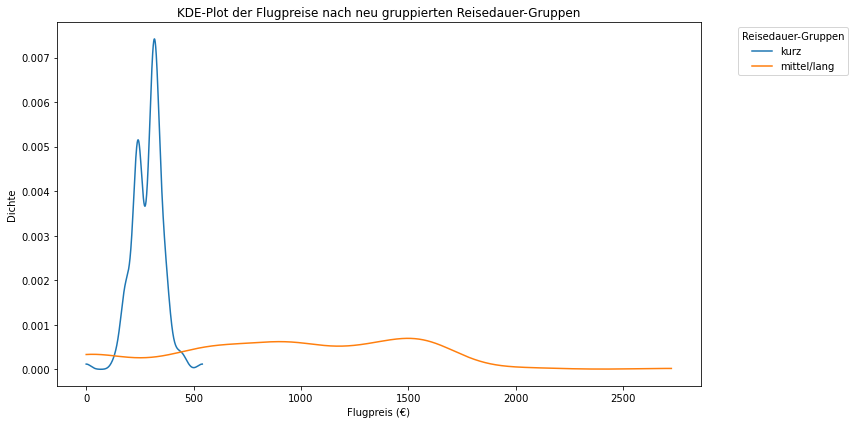


Kruskal-Wallis-Statistik (vereinfacht): 281.37486799232437
P-Wert (vereinfacht): 3.7669612953426077e-63

Signifikante Unterschiede zwischen den neu gruppierten Gruppen nachgewiesen.


In [30]:
# Neu-Gruppierung der Reisedauer-Gruppen basierend auf den Dunn-Test-Ergebnissen
df['travel_duration_group_simplified'] = df['travel_duration_group'].replace({
    'lang': 'mittel/lang',
    'mittel': 'mittel/lang',
    'kurz': 'kurz'
})

# Deskriptive Statistiken der Preise nach neu gruppierten Reisedauer-Gruppen
travel_duration_stats_simplified = df.groupby('travel_duration_group_simplified').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
)

# Ausgabe der deskriptiven Statistik
print(travel_duration_stats_simplified)

# KDE-Plot für die neu gruppierten Reisedauer-Gruppen
plt.figure(figsize=(12, 6))

for group in df['travel_duration_group_simplified'].unique():
    subset = df[df['travel_duration_group_simplified'] == group]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=group)

plt.title('KDE-Plot der Flugpreise nach neu gruppierten Reisedauer-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Reisedauer-Gruppen', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Durchführung des Kruskal-Wallis-Tests für die neu gruppierten Reisedauer-Gruppen
groups_simplified = [df[df['travel_duration_group_simplified'] == group]['price'] for group in df['travel_duration_group_simplified'].unique()]
kruskal_stat_simplified, kruskal_p_value_simplified = kruskal(*groups_simplified)

print(f"\nKruskal-Wallis-Statistik (vereinfacht): {kruskal_stat_simplified}")
print(f"P-Wert (vereinfacht): {kruskal_p_value_simplified}")

# Überprüfen, ob signifikante Unterschiede bestehen
if kruskal_p_value_simplified < 0.05:
    print("\nSignifikante Unterschiede zwischen den neu gruppierten Gruppen nachgewiesen.")
else:
    print("\nKeine signifikanten Unterschiede zwischen den neu gruppierten Gruppen.")

# Wetter

## Temperatur Abflughafen

### Durchschnittstemperatur am Abflughafen und Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die deskriptiven Statistiken der **Durchschnittstemperatur am Abflughafen (tavg_departure)**:

| Metrik     | Wert   |
|------------|--------|
| Anzahl     | 788    |
| Mittelwert | 21.48 °C |
| Standardabweichung | 2.49 °C |
| Minimum    | 17.50 °C |
| 25. Perzentil | 19.60 °C |
| Median     | 21.50 °C |
| 75. Perzentil | 23.50 °C |
| Maximum    | 26.80 °C |

Die Temperaturen am Abflughafen liegen im Beobachtungszeitraum zwischen **17.5°C und 26.8°C**, wobei der Mittelwert bei **21.48°C** liegt.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen in Abhängigkeit von der Durchschnittstemperatur am Abflughafen.  
**H1**: Mindestens eine Temperaturgruppe führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Um zu überprüfen, ob die Temperatur am Abflughafen Einfluss auf die Flugpreise hat, wurde der Kruskal-Wallis-Test durchgeführt.

- **Kruskal-Wallis-Statistik**: 0.027  
- **P-Wert**: 0.869  

Da der P-Wert deutlich größer als 0.05 ist, können wir die Nullhypothese **nicht ablehnen**. Dies bedeutet, dass **keine signifikanten Unterschiede** in den Flugpreisen in Abhängigkeit von der Durchschnittstemperatur am Abflughafen bestehen.

#### Schlussfolgerung:
Die **Durchschnittstemperatur am Abflughafen** hat **keinen signifikanten Einfluss** auf die Flugpreise. Daher wird dieses Feature in der weiteren Analyse nicht als relevantes Merkmal betrachtet.

In [31]:
# Deskriptive Statistiken für tavg_departure und tavg_destination
tavg_departure_stats = df['tavg_departure'].describe()
tavg_destination_stats = df['tavg_destination'].describe()

print("Deskriptive Statistiken für tavg_departure:")
print(tavg_departure_stats)

Deskriptive Statistiken für tavg_departure:
count    788.000000
mean      21.480964
std        2.485898
min       17.500000
25%       19.600000
50%       21.500000
75%       23.500000
max       26.800000
Name: tavg_departure, dtype: float64


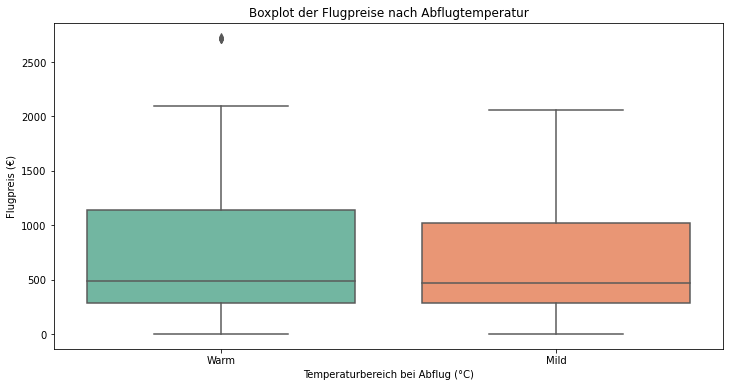

In [32]:
# Temperaturkategorien definieren und einer neuen Spalte zuordnen
def categorize_temp(temp):
    if temp < 10:
        return 'Kalt'
    elif 10 <= temp < 20:
        return 'Mild'
    elif 20 <= temp < 30:
        return 'Warm'
    elif 30 <= temp < 40:
        return 'Heiß'
    else:
        return 'Extrem Heiß'

df['temp_cat_departure'] = df['tavg_departure'].apply(categorize_temp)

# Boxplot der Flugpreise nach Abflugtemperatur-Kategorien
plt.figure(figsize=(12, 6))

sns.boxplot(x='temp_cat_departure', y='price', data=df, palette='Set2')

plt.title('Boxplot der Flugpreise nach Abflugtemperatur')
plt.xlabel('Temperaturbereich bei Abflug (°C)')
plt.ylabel('Flugpreis (€)')
plt.show()

In [33]:
# Temperatur in Kategorien einteilen
def categorize_temperature(temp):
    if temp < 10:
        return 'niedrig'
    elif 10 <= temp < 20:
        return 'mittel'
    else:
        return 'hoch'

df['temp_category_departure'] = df['tavg_departure'].apply(categorize_temperature)

# Kruskal-Wallis-Test
from scipy import stats

categories = df['temp_category_departure'].unique()
grouped_prices = [df[df['temp_category_departure'] == category]['price'] for category in categories]

kruskal_stat, kruskal_p_value = stats.kruskal(*grouped_prices)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {kruskal_p_value}")

Kruskal-Wallis-Statistik: 0.02724022237662553
P-Wert: 0.8689076797341933


## Temperatur Zielort

### Durchschnittstemperatur am Zielort und Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die deskriptiven Statistiken der **Zieltemperaturkategorien (Mild, Warm, Heiß)** und deren Auswirkungen auf die Flugpreise:

| Temperaturkategorie | Anzahl | Mittelwert (€) | Standardabweichung (€) | Minimum (€) | 25% (€) | Median (€) | 75% (€) | Maximum (€) |
|---------------------|--------|----------------|------------------------|-------------|---------|------------|---------|-------------|
| Mild                | 237    | 504.63         | 458.93                 | 0.00        | 235.67  | 313.08     | 567.00  | 1922.00      |
| Warm                | 385    | 642.50         | 535.79                 | 0.00        | 243.65  | 333.60     | 995.00  | 2060.00      |
| Heiß                | 166    | 1083.91        | 493.05                 | 288.00      | 659.00  | 980.98     | 1521.76 | 2725.00      |

- Die **mittleren Flugpreise** steigen mit der Zieltemperatur: Flüge zu **heißen** Zielorten sind tendenziell teurer, mit einem Mittelwert von **1083.91€**, während Flüge zu **milden** Zielen im Durchschnitt bei **504.63€** liegen.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Zieltemperatur-Kategorien.  
**H1**: Mindestens eine Temperaturkategorie führt zu **signifikant unterschiedlichen** Preisen.

#### Kruskal-Wallis-Test:
Der Kruskal-Wallis-Test wurde verwendet, um festzustellen, ob die Durchschnittstemperatur am Zielort einen signifikanten Einfluss auf die Flugpreise hat.

- **Kruskal-Wallis-Statistik**: 131.07  
- **P-Wert**: 3.46e-29  

Da der P-Wert sehr viel kleiner als 0.05 ist, wird die Nullhypothese **abgelehnt**. Es gibt also signifikante Unterschiede zwischen den Flugpreisen in Abhängigkeit von der Zieltemperatur.

#### Post-hoc Dunn-Test:
Da der Kruskal-Wallis-Test signifikante Unterschiede gezeigt hat, wurde ein Post-hoc Dunn-Test durchgeführt, um zu sehen, **welche Kategorien sich signifikant unterscheiden**.

| Vergleich  | P-Wert       | Signifikant |
|------------|--------------|-------------|
| Mild vs Warm | 0.00216   | Ja          |
| Mild vs Heiß | 2.19e-28   | Ja          |
| Warm vs Heiß | 1.79e-19   | Ja          |

Alle **Temperaturkategorien unterscheiden sich signifikant** voneinander. Die Preise steigen deutlich an, je heißer das Ziel ist, insbesondere im Vergleich zu milden oder warmen Zielen.

#### Schlussfolgerung:
Die Zieltemperatur hat einen **deutlichen Einfluss** auf die Flugpreise. **Heißere Zielorte** sind mit signifikant höheren Flugpreisen verbunden, was vermutlich auf eine **größere Nachfrage** oder auf spezifische Bedingungen in diesen Regionen zurückzuführen ist. Diese Ergebnisse bestätigen die Relevanz der Zieltemperatur als einflussreiches Feature für die Preisanalyse.


In [34]:
# Zieltemperatur kategorisieren
df['temp_cat_dest'] = pd.cut(df['tavg_destination'], bins=[-np.inf, 10, 20, 30, np.inf], labels=['Kalt', 'Mild', 'Warm', 'Heiß'])

# Deskriptive Statistiken nach Temperaturkategorien am Zielort
deskriptive_statistiken_dest = df.groupby('temp_cat_dest')['price'].describe()
deskriptive_statistiken_dest

,count,mean,std,min,25%,50%,75%,max
temp_cat_dest,,,,,,,,
Kalt,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mild,237.0,504.633937,458.930052,0.0,235.67,313.08,567.00,1922.0
Warm,385.0,642.501462,535.787717,0.0,243.65,333.60,995.00,2060.0
Heiß,166.0,1083.909639,493.045681,288.0,659.00,980.98,1521.76,2725.0


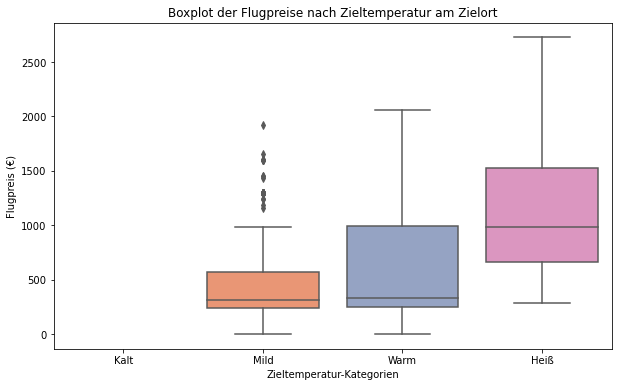

In [35]:
# Boxplot der Flugpreise nach Zieltemperatur-Kategorien am Zielort
plt.figure(figsize=(10, 6))

sns.boxplot(x='temp_cat_dest', y='price', data=df, palette='Set2')

plt.title('Boxplot der Flugpreise nach Zieltemperatur am Zielort')
plt.xlabel('Zieltemperatur-Kategorien')
plt.ylabel('Flugpreis (€)')
plt.show()

In [36]:
# Subsets für jede Temperaturkategorie
subset_mild = df[df['temp_cat_dest'] == 'Mild']['price']
subset_warm = df[df['temp_cat_dest'] == 'Warm']['price']
subset_heiss = df[df['temp_cat_dest'] == 'Heiß']['price']

# Kruskal-Wallis-Test durchführen
kruskal_stat, p_value = kruskal(subset_mild, subset_warm, subset_heiss)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {p_value}")

# Ergebnis interpretieren
if p_value < 0.05:
    print("Es gibt signifikante Unterschiede zwischen den Flugpreisen in den verschiedenen Zieltemperatur-Kategorien.")
    
    # Post-hoc Dunn-Test durchführen
    posthoc_dunn = sp.posthoc_dunn(
        df, 
        val_col='price', 
        group_col='temp_cat_dest', 
        p_adjust='bonferroni'
    )
    
    # Ergebnis anzeigen
    print("\nPost-hoc Dunn-Test Ergebnisse:\n", posthoc_dunn)
else:
    print("Es gibt keine signifikanten Unterschiede zwischen den Flugpreisen in den verschiedenen Zieltemperatur-Kategorien.")

Kruskal-Wallis-Statistik: 131.06843091985118
P-Wert: 3.4582138826715427e-29
Es gibt signifikante Unterschiede zwischen den Flugpreisen in den verschiedenen Zieltemperatur-Kategorien.

Post-hoc Dunn-Test Ergebnisse:
               Mild          Warm          Heiß
Mild  1.000000e+00  2.161664e-03  2.186029e-28
Warm  2.161664e-03  1.000000e+00  1.788297e-19
Heiß  2.186029e-28  1.788297e-19  1.000000e+00


# Niederschlag Departure

### Niederschlagskategorien am Abflugort und deren Einfluss auf Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die deskriptiven Statistiken der **Niederschlagskategorien am Abflugort** und deren durchschnittliche Auswirkungen auf die Flugpreise:

| Niederschlagskategorie | Anzahl | Mittelwert (€) | Standardabweichung (€) | Minimum (€) | 25% (€) | Median (€) | 75% (€) | Maximum (€) |
|------------------------|--------|----------------|------------------------|-------------|---------|------------|---------|-------------|
| Kein Niederschlag       | 485    | 697.22         | 552.57                 | 0.00        | 281.00  | 488.00     | 1140.00 | 2708.00      |
| Leichter Niederschlag   | 89     | 661.09         | 519.22                 | 1.02        | 241.08  | 424.00     | 997.50  | 1646.79      |
| Mäßiger Niederschlag    | 30     | 680.84         | 549.21                 | 1.05        | 241.72  | 529.50     | 1216.96 | 1653.00      |
| Starker Niederschlag    | 184    | 703.67         | 545.38                 | 0.00        | 312.06  | 482.50     | 1050.05 | 2725.00      |

- Unabhängig von der Niederschlagsstärke gibt es **keine auffälligen Unterschiede** in den durchschnittlichen Flugpreisen.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Niederschlagskategorien am Abflugort.  
**H1**: Mindestens eine Niederschlagskategorie am Abflugort führt zu **signifikant unterschiedlichen** Flugpreisen.

#### Kruskal-Wallis-Test:
Der Kruskal-Wallis-Test wurde verwendet, um festzustellen, ob die Niederschlagskategorien am Abflugort einen signifikanten Einfluss auf die Flugpreise haben.

- **Kruskal-Wallis-Statistik**: 1.26  
- **P-Wert**: 0.7397  

Da der P-Wert weit größer als 0.05 ist, wird die Nullhypothese **nicht abgelehnt**. Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Niederschlagskategorien am Abflugort.

#### Schlussfolgerung:
Der Niederschlag am Abflugort hat **keinen signifikanten Einfluss** auf die Flugpreise. Dies könnte darauf hindeuten, dass die Flugpreise unabhängig von den Wetterbedingungen am Abflugort festgelegt werden oder dass kurzfristige Last-Minute-Flüge durch andere Faktoren wie Zielort, Fluggesellschaft oder Reisedauer stärker beeinflusst werden.

In [37]:
# Kategorisierung des Niederschlags
def categorize_precipitation(prcp):
    if prcp == 0:
        return 'Kein Niederschlag'
    elif 0 < prcp <= 2.5:
        return 'Leichter Niederschlag'
    elif 2.5 < prcp <= 7.6:
        return 'Mäßiger Niederschlag'
    else:
        return 'Starker Niederschlag'

# Anwenden der Kategorisierung
df['prcp_cat_departure'] = df['prcp_departure'].apply(categorize_precipitation)

# Deskriptive Statistik
prcp_stats = df.groupby('prcp_cat_departure')['price'].describe()
prcp_stats

,count,mean,std,min,25%,50%,75%,max
prcp_cat_departure,,,,,,,,
Kein Niederschlag,485.0,697.220996,552.569958,0.000,281.0000,488.0,1140.0000,2708.00
Leichter Niederschlag,89.0,661.087247,519.217891,1.021,241.0800,424.0,997.5000,1646.79
Mäßiger Niederschlag,30.0,680.842933,549.206873,1.054,241.7225,529.5,1216.9625,1653.00
Starker Niederschlag,184.0,703.674293,545.377234,0.000,312.0600,482.5,1050.0525,2725.00


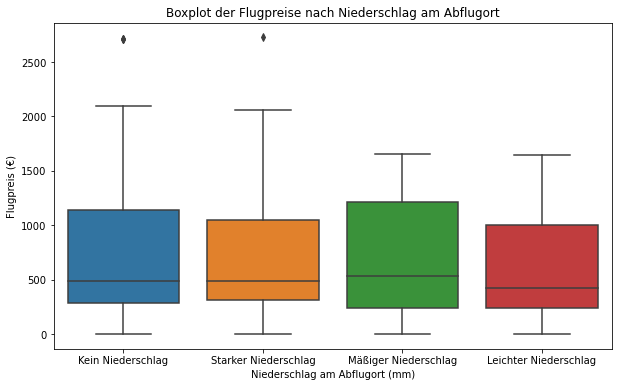

In [38]:
# Boxplot der Flugpreise nach Niederschlagskategorien am Abflugort
plt.figure(figsize=(10, 6))
sns.boxplot(x='prcp_cat_departure', y='price', data=df)
plt.title('Boxplot der Flugpreise nach Niederschlag am Abflugort')
plt.xlabel('Niederschlag am Abflugort (mm)')
plt.ylabel('Flugpreis (€)')
plt.show()

In [39]:
# Subsets für jede Niederschlagskategorie
subset_keiner = df[df['prcp_cat_departure'] == 'Kein Niederschlag']['price']
subset_leicht = df[df['prcp_cat_departure'] == 'Leichter Niederschlag']['price']
subset_maessig = df[df['prcp_cat_departure'] == 'Mäßiger Niederschlag']['price']
subset_stark = df[df['prcp_cat_departure'] == 'Starker Niederschlag']['price']

# Kruskal-Wallis-Test durchführen
kruskal_stat, p_value = kruskal(subset_keiner, subset_leicht, subset_maessig, subset_stark)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {p_value}")

# Ergebnis interpretieren
if p_value < 0.05:
    print("Es gibt signifikante Unterschiede zwischen den Flugpreisen in den verschiedenen Niederschlagskategorien am Abflugort.")
else:
    print("Es gibt keine signifikanten Unterschiede zwischen den Flugpreisen in den verschiedenen Niederschlagskategorien am Abflugort.")

Kruskal-Wallis-Statistik: 1.2557024781658117
P-Wert: 0.7396778513550344
Es gibt keine signifikanten Unterschiede zwischen den Flugpreisen in den verschiedenen Niederschlagskategorien am Abflugort.


# Niederschlag arrival

### Niederschlagskategorien am Zielort und deren Einfluss auf Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die deskriptiven Statistiken der **Niederschlagskategorien am Zielort** und deren durchschnittliche Auswirkungen auf die Flugpreise:

| Niederschlagskategorie     | Anzahl | Mittelwert (€) | Standardabweichung (€) | Minimum (€) | 25% (€)  | Median (€) | 75% (€)    | Maximum (€) |
|----------------------------|--------|----------------|------------------------|-------------|----------|------------|------------|-------------|
| Kein Niederschlag           | 455    | 690.31         | 542.70                 | 0.00        | 276.65   | 527.00     | 995.50     | 2725.00      |
| Leichter Niederschlag       | 111    | 701.38         | 586.30                 | 1.02        | 241.08   | 369.00     | 1390.44    | 1922.00      |
| Mäßiger Niederschlag        | 76     | 708.50         | 549.09                 | 1.19        | 313.08   | 369.00     | 1295.00    | 1923.00      |
| Starker Niederschlag        | 146    | 692.47         | 529.41                 | 0.00        | 292.05   | 483.00     | 1110.02    | 2059.00      |

- Es gibt **keine auffälligen Unterschiede** zwischen den Niederschlagskategorien in Bezug auf den durchschnittlichen Flugpreis.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Niederschlagskategorien am Zielort.  
**H1**: Mindestens eine Niederschlagskategorie am Zielort führt zu **signifikant unterschiedlichen** Flugpreisen.

#### Kruskal-Wallis-Test:
Der Kruskal-Wallis-Test wurde verwendet, um festzustellen, ob die Niederschlagskategorien am Zielort einen signifikanten Einfluss auf die Flugpreise haben.

- **Kruskal-Wallis-Statistik**: 0.47  
- **P-Wert**: 0.9256  

Da der P-Wert weit größer als 0.05 ist, wird die Nullhypothese **nicht abgelehnt**. Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Niederschlagskategorien am Zielort.

#### Schlussfolgerung:
Der Niederschlag am Zielort hat **keinen signifikanten Einfluss** auf die Flugpreise. Diese Ergebnisse stimmen mit den Beobachtungen für den Abflugort überein, was darauf hindeutet, dass Wetterbedingungen (insbesondere Niederschläge) bei der Preisgestaltung für kurzfristige Last-Minute-Flüge eine untergeordnete Rolle spielen könnten.


                       count        mean         std    min     25%    50%  \
prcp_cat_dest                                                                
Kein Niederschlag      455.0  690.306958  542.699817  0.000  276.65  527.0   
Leichter Niederschlag  111.0  701.383703  586.302560  1.021  241.08  369.0   
Mäßiger Niederschlag    76.0  708.502816  549.091987  1.186  313.08  369.0   
Starker Niederschlag   146.0  692.471473  529.409199  0.000  292.05  483.0   

                             75%     max  
prcp_cat_dest                             
Kein Niederschlag       995.5000  2725.0  
Leichter Niederschlag  1390.4350  1922.0  
Mäßiger Niederschlag   1295.0000  1923.0  
Starker Niederschlag   1110.0175  2059.0  


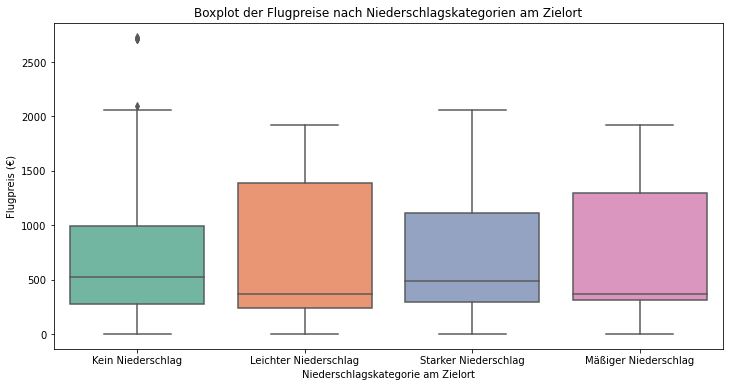

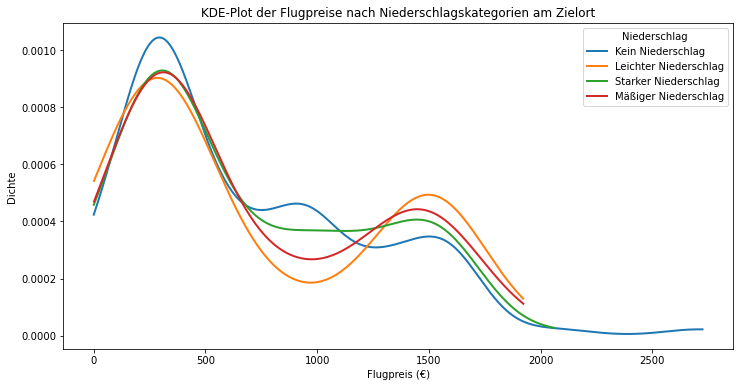

Kruskal-Wallis-Statistik: 0.4691397967385568
P-Wert: 0.9256170299999489


In [40]:
# Beispielhafte Niederschlagskategorisierung
def categorize_precipitation(prcp):
    if prcp == 0:
        return 'Kein Niederschlag'
    elif 0 < prcp <= 2:
        return 'Leichter Niederschlag'
    elif 2 < prcp <= 10:
        return 'Mäßiger Niederschlag'
    else:
        return 'Starker Niederschlag'

# Niederschlagskategorien anwenden
df['prcp_cat_dest'] = df['prcp_destination'].apply(categorize_precipitation)

# Deskriptive Statistiken für jede Niederschlagskategorie am Zielort
desc_stats_prcp = df.groupby('prcp_cat_dest')['price'].describe()
print(desc_stats_prcp)

# Boxplot der Flugpreise nach Niederschlagskategorien am Zielort
plt.figure(figsize=(12, 6))
sns.boxplot(x='prcp_cat_dest', y='price', data=df, palette='Set2')
plt.title('Boxplot der Flugpreise nach Niederschlagskategorien am Zielort')
plt.xlabel('Niederschlagskategorie am Zielort')
plt.ylabel('Flugpreis (€)')
plt.show()

# KDE-Plot der Flugpreise nach Niederschlagskategorien am Zielort
plt.figure(figsize=(12, 6))
for category in df['prcp_cat_dest'].unique():
    subset = df[df['prcp_cat_dest'] == category]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(subset.min(), subset.max(), 1000)
        density = kde(price_range)
        plt.plot(price_range, density, label=category, linewidth=2)

plt.title('KDE-Plot der Flugpreise nach Niederschlagskategorien am Zielort')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Niederschlag')
plt.show()

# Kruskal-Wallis-Test durchführen
kruskal_stat, kruskal_p_value = kruskal(
    *[df[df['prcp_cat_dest'] == category]['price'] for category in df['prcp_cat_dest'].unique()]
)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {kruskal_p_value}")

# Windgeschwindigkeit departure

### Windgeschwindigkeit am Abflughafen und deren Einfluss auf die Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die deskriptiven Statistiken der **Windgeschwindigkeitskategorien am Abflughafen** und deren durchschnittliche Auswirkungen auf die Flugpreise:

| Windgeschwindigkeitskategorie | Anzahl | Mittelwert (€) | Standardabweichung (€) | Minimum (€) | 25% (€) | Median (€) | 75% (€)  | Maximum (€) |
|-------------------------------|--------|----------------|------------------------|-------------|---------|------------|----------|-------------|
| Mäßig                          | 758    | 692.62         | 547.54                 | 0.00        | 281.00  | 483.00     | 1021.52  | 2725.00      |
| Stark                          | 30     | 729.53         | 519.35                 | 207.60      | 282.00  | 536.50     | 1182.88  | 1615.00      |

- Die durchschnittlichen Flugpreise für mäßigen und starken Wind sind ähnlich, wobei bei starkem Wind der Median leicht höher liegt.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Windgeschwindigkeitskategorien am Abflughafen.  
**H1**: Mindestens eine Windgeschwindigkeitskategorie am Abflughafen führt zu **signifikant unterschiedlichen** Flugpreisen.

#### Mann-Whitney-U-Test:
Da es nur zwei Kategorien gibt (mäßig und stark), wurde der Mann-Whitney-U-Test verwendet, um die Unterschiede zwischen den beiden Gruppen zu untersuchen.

- **Mann-Whitney-U-Statistik**: 11093.5  
- **P-Wert**: 0.8213  

Der P-Wert ist weit größer als 0.05, daher wird die Nullhypothese **nicht abgelehnt**. Es gibt **keine signifikanten Unterschiede** zwischen den Flugpreisen bei mäßigen und starken Windgeschwindigkeiten am Abflughafen.

#### Schlussfolgerung:
Die Windgeschwindigkeit am Abflughafen hat **keinen signifikanten Einfluss** auf die Flugpreise. Obwohl leichte Schwankungen in den Mittelwerten und Medians vorhanden sind, sind diese Unterschiede statistisch nicht bedeutsam.

                          count        mean         std    min    25%    50%  \
wind_speed_cat_departure                                                       
Mäßig                     758.0  692.618135  547.536376    0.0  281.0  483.0   
Stark                      30.0  729.525333  519.352857  207.6  282.0  536.5   

                                75%     max  
wind_speed_cat_departure                     
Mäßig                     1021.5175  2725.0  
Stark                     1182.8750  1615.0  


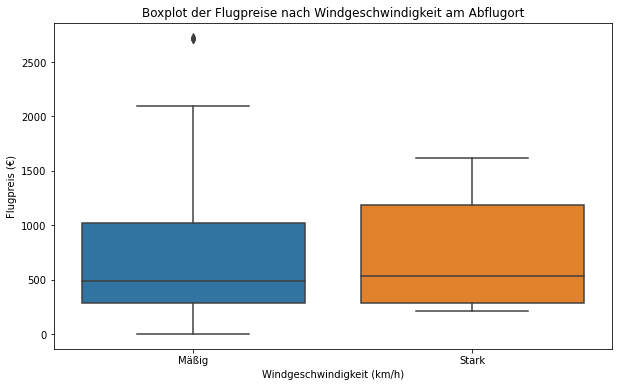

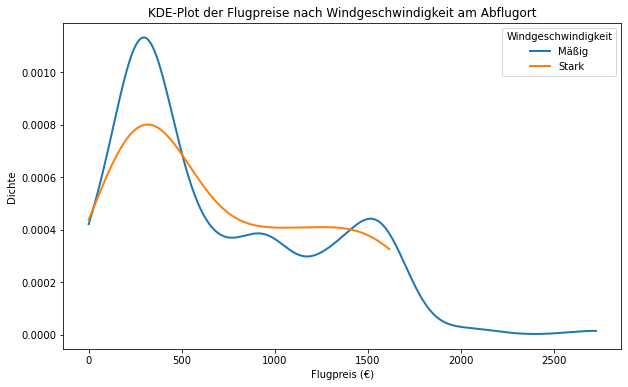

Mann-Whitney-U-Statistik: 11093.5
P-Wert: 0.8213374184255904


In [41]:
# 1. Windgeschwindigkeit kategorisieren
def categorize_wind_speed(speed):
    if speed < 5:
        return 'Schwach'
    elif 5 <= speed < 15:
        return 'Mäßig'
    elif 15 <= speed < 25:
        return 'Stark'
    else:
        return 'Sehr stark'

df['wind_speed_cat_departure'] = df['wspd_departure'].apply(categorize_wind_speed)

# 2. Deskriptive Statistiken berechnen
wind_speed_stats = df.groupby('wind_speed_cat_departure')['price'].describe()
print(wind_speed_stats)

# 3. Boxplot erstellen
plt.figure(figsize=(10, 6))
sns.boxplot(x='wind_speed_cat_departure', y='price', data=df)
plt.title('Boxplot der Flugpreise nach Windgeschwindigkeit am Abflugort')
plt.xlabel('Windgeschwindigkeit (km/h)')
plt.ylabel('Flugpreis (€)')
plt.show()

# 4. KDE-Plot erstellen
plt.figure(figsize=(10, 6))
for category in df['wind_speed_cat_departure'].unique():
    subset = df[df['wind_speed_cat_departure'] == category]['price']
    kde = gaussian_kde(subset)
    price_range = np.linspace(0, subset.max(), 1000)
    density = kde(price_range)
    density[density < 0] = 0
    plt.plot(price_range, density, label=category, linewidth=2)

plt.title('KDE-Plot der Flugpreise nach Windgeschwindigkeit am Abflugort')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Windgeschwindigkeit')
plt.show()

from scipy.stats import mannwhitneyu

# Mann-Whitney-U-Test für zwei Gruppen
group_1 = df[df['wind_speed_cat_departure'] == 'Mäßig']['price']
group_2 = df[df['wind_speed_cat_departure'] == 'Stark']['price']

stat, p_value = mannwhitneyu(group_1, group_2)

print(f"Mann-Whitney-U-Statistik: {stat}")
print(f"P-Wert: {p_value}")

# Windgeschwindigkeit arrival

### Windgeschwindigkeit am Zielort und deren Einfluss auf die Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die deskriptiven Statistiken der **Windgeschwindigkeitskategorien am Zielort** und deren durchschnittliche Auswirkungen auf die Flugpreise:

| Windgeschwindigkeitskategorie | Anzahl | Mittelwert (€) | Standardabweichung (€) | Minimum (€) | 25% (€) | Median (€) | 75% (€)  | Maximum (€) |
|-------------------------------|--------|----------------|------------------------|-------------|---------|------------|----------|-------------|
| Leicht                        | 209    | 732.27         | 551.36                 | 1.02        | 315.98  | 401.00     | 1296.00  | 1923.00      |
| Mäßig                         | 474    | 710.22         | 549.42                 | 0.00        | 288.00  | 526.50     | 1174.50  | 2725.00      |
| Sehr Stark                    | 4      | 438.83         | 563.84                 | 1.01        | 182.99  | 243.65     | 499.49   | 1267.00      |
| Stark                         | 101    | 548.97         | 500.25                 | 1.01        | 235.73  | 362.65     | 807.00   | 2707.00      |

- Die durchschnittlichen Flugpreise scheinen mit der Windstärke leicht zu variieren, wobei der Preis bei leichter Windgeschwindigkeit höher liegt als bei starker Windgeschwindigkeit.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den verschiedenen Windgeschwindigkeitskategorien am Zielort.  
**H1**: Mindestens eine Windgeschwindigkeitskategorie am Zielort führt zu **signifikant unterschiedlichen** Flugpreisen.

#### Kruskal-Wallis-Test:
- **Kruskal-Wallis-Statistik**: 13.35  
- **P-Wert**: 0.0039  

Da der P-Wert kleiner als 0.05 ist, lehnen wir die Nullhypothese ab. Es gibt **signifikante Unterschiede** zwischen den Windgeschwindigkeitskategorien hinsichtlich der Flugpreise.

#### Post-hoc Dunn-Test:
| Vergleich            | P-Wert       | Signifikant |
|----------------------|--------------|-------------|
| Leicht vs. Mäßig      | 1.000000     | Nein        |
| Leicht vs. Sehr Stark | 0.649175     | Nein        |
| Leicht vs. Stark      | 0.005458     | Ja          |
| Mäßig vs. Sehr Stark  | 0.897342     | Nein        |
| Mäßig vs. Stark       | 0.024487     | Ja          |
| Sehr Stark vs. Stark  | 1.000000     | Nein        |

Es gibt **signifikante Unterschiede** zwischen den Flugpreisen bei leichten/mäßigen Windgeschwindigkeiten und starken Windgeschwindigkeiten, jedoch keine signifikanten Unterschiede zwischen den anderen Kategorien.

#### Neue Gruppierung:
Basierend auf den Ergebnissen des Dunn-Tests haben wir die Windgeschwindigkeitskategorien neu gruppiert:

- **Niedrig-Mittel**: Leicht und Mäßig
- **Hoch**: Stark und Sehr Stark

Dies reduziert die Komplexität der Gruppen und fokussiert die Analyse auf die Kategorien, die sich signifikant voneinander unterscheiden.

                        count        mean         std    min        25%  \
wind_speed_cat_arrival                                                    
Leicht                  209.0  732.274493  551.355384  1.021  315.98000   
Mäßig                   474.0  710.217675  549.421786  0.000  288.00000   
Sehr Stark                4.0  438.827250  563.838996  1.009  182.98975   
Stark                   101.0  548.974752  500.254240  1.008  235.73000   

                           50%        75%     max  
wind_speed_cat_arrival                             
Leicht                  401.00  1296.0000  1923.0  
Mäßig                   526.50  1174.5000  2725.0  
Sehr Stark              243.65   499.4875  1267.0  
Stark                   362.65   807.0000  2707.0  


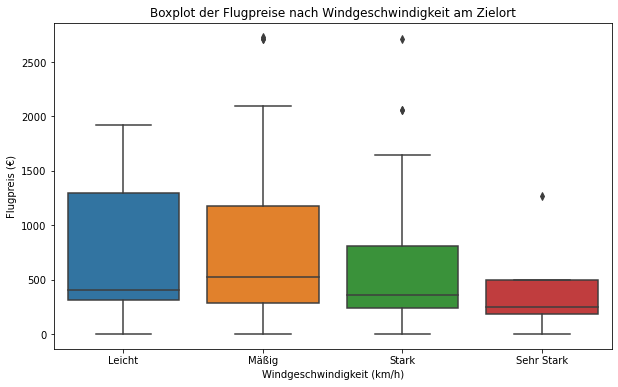

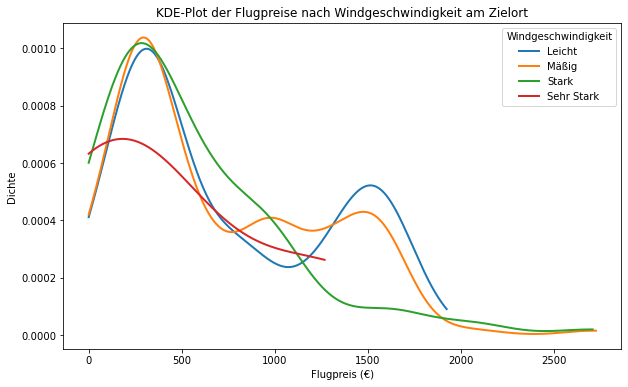

Kruskal-Wallis-Statistik: 13.34646126073626
P-Wert: 0.003944236530451011

Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.

Post-hoc Dunn-Test Ergebnisse:
               Leicht     Mäßig  Sehr Stark     Stark
Leicht      1.000000  1.000000    0.649175  0.005458
Mäßig       1.000000  1.000000    0.897342  0.024487
Sehr Stark  0.649175  0.897342    1.000000  1.000000
Stark       0.005458  0.024487    1.000000  1.000000


In [42]:
# Windgeschwindigkeit kategorisieren
def categorize_wind_speed(speed):
    if speed < 10:
        return 'Leicht'
    elif 10 <= speed < 20:
        return 'Mäßig'
    elif 20 <= speed < 30:
        return 'Stark'
    else:
        return 'Sehr Stark'

df['wind_speed_cat_arrival'] = df['wspd_destination'].apply(categorize_wind_speed)

# Deskriptive Statistiken der Flugpreise nach Windgeschwindigkeit
wind_speed_stats = df.groupby('wind_speed_cat_arrival')['price'].describe()
print(wind_speed_stats)

# Boxplot der Flugpreise nach Windgeschwindigkeit am Zielort
plt.figure(figsize=(10, 6))
sns.boxplot(x='wind_speed_cat_arrival', y='price', data=df)
plt.title('Boxplot der Flugpreise nach Windgeschwindigkeit am Zielort')
plt.xlabel('Windgeschwindigkeit (km/h)')
plt.ylabel('Flugpreis (€)')
plt.show()

# KDE-Plot der Flugpreise nach Windgeschwindigkeit am Zielort
plt.figure(figsize=(10, 6))
for category in df['wind_speed_cat_arrival'].unique():
    subset = df[df['wind_speed_cat_arrival'] == category]['price']
    kde = gaussian_kde(subset)
    price_range = np.linspace(0, subset.max(), 1000)
    density = kde(price_range)
    density[density < 0] = 0
    
    plt.plot(price_range, density, label=category, linewidth=2)

plt.title('KDE-Plot der Flugpreise nach Windgeschwindigkeit am Zielort')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Windgeschwindigkeit')
plt.show()

# Kruskal-Wallis-Test durchführen
stat, p_value = kruskal(
    df[df['wind_speed_cat_arrival'] == 'Leicht']['price'],
    df[df['wind_speed_cat_arrival'] == 'Mäßig']['price'],
    df[df['wind_speed_cat_arrival'] == 'Stark']['price'],
    df[df['wind_speed_cat_arrival'] == 'Sehr Stark']['price']
)

print(f"Kruskal-Wallis-Statistik: {stat}")
print(f"P-Wert: {p_value}")

# Post-hoc Dunn-Test durchführen, wenn signifikante Unterschiede vorliegen
if p_value < 0.05:
    print("\nSignifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.\n")
    
    # Post-hoc Dunn-Test
    posthoc_dunn = sp.posthoc_dunn(df, val_col='price', group_col='wind_speed_cat_arrival', p_adjust='bonferroni')
    
    # Ergebnis anzeigen
    print("Post-hoc Dunn-Test Ergebnisse:\n", posthoc_dunn)
else:
    print("Keine signifikanten Unterschiede zwischen den Gruppen.")

                             count        mean         std    min     25%  \
wind_speed_group_simplified                                                 
Hoch                         105.0  544.778657  500.248543  1.008  235.73   
Niedrig-Mittel               683.0  716.967126  549.703829  0.000  299.65   

                                50%     75%     max  
wind_speed_group_simplified                          
Hoch                         362.65   807.0  2707.0  
Niedrig-Mittel               493.00  1295.0  2725.0  


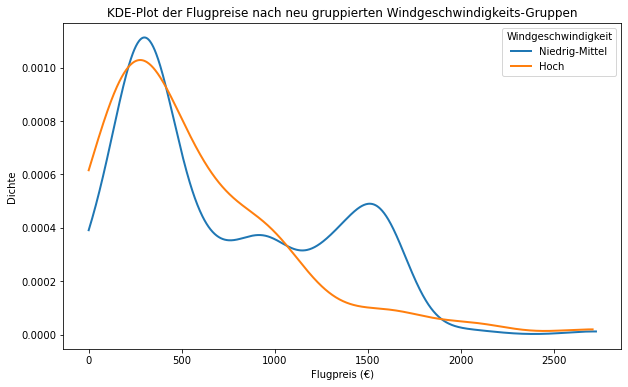


Kruskal-Wallis-Statistik (vereinfacht): 11.599274061333764
P-Wert (vereinfacht): 0.0006597756826555476


In [43]:
# Neue Gruppierung der Windgeschwindigkeit basierend auf den Dunn-Test-Ergebnissen
df['wind_speed_group_simplified'] = df['wind_speed_cat_arrival'].replace({
    'Leicht': 'Niedrig-Mittel',
    'Mäßig': 'Niedrig-Mittel',
    'Stark': 'Hoch',
    'Sehr Stark': 'Hoch'
})

# Deskriptive Statistiken der Preise nach neu gruppierten Windgeschwindigkeits-Gruppen
wind_speed_stats_simplified = df.groupby('wind_speed_group_simplified')['price'].describe()
print(wind_speed_stats_simplified)

# KDE-Plot für die neu gruppierten Windgeschwindigkeits-Gruppen
plt.figure(figsize=(10, 6))
for group in df['wind_speed_group_simplified'].unique():
    subset = df[df['wind_speed_group_simplified'] == group]['price']
    kde = gaussian_kde(subset)
    price_range = np.linspace(0, subset.max(), 1000)
    density = kde(price_range)
    density[density < 0] = 0
    
    plt.plot(price_range, density, label=group, linewidth=2)

plt.title('KDE-Plot der Flugpreise nach neu gruppierten Windgeschwindigkeits-Gruppen')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Windgeschwindigkeit')
plt.show()

# Durchführung des Kruskal-Wallis-Tests für die neu gruppierten Windgeschwindigkeits-Gruppen
groups_simplified = [df[df['wind_speed_group_simplified'] == group]['price'] for group in df['wind_speed_group_simplified'].unique()]
kruskal_stat_simplified, kruskal_p_value_simplified = kruskal(*groups_simplified)

print(f"\nKruskal-Wallis-Statistik (vereinfacht): {kruskal_stat_simplified}")
print(f"P-Wert (vereinfacht): {kruskal_p_value_simplified}")

# Adj. Close

### Schlusskurskategorien und deren Einfluss auf die Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die **Schlusskurskategorien** (Börsenwertkategorien des Unternehmens) und deren durchschnittlichen Einfluss auf die Flugpreise:

| Schlusskurskategorie | Anzahl | Mittelwert (€) | Standardabweichung (€) | Minimum (€) | 25% (€) | Median (€) | 75% (€)  | Maximum (€) |
|----------------------|--------|----------------|------------------------|-------------|---------|------------|----------|-------------|
| Niedrig               | 252    | 655.54         | 546.19                 | 141.00      | 243.65  | 315.98     | 982.85   | 1713.90      |
| Mittel                | 196    | 642.59         | 525.09                 | 177.60      | 243.65  | 325.30     | 1019.91  | 1617.87      |
| Hoch                  | 213    | 946.80         | 515.13                 | 193.00      | 548.00  | 789.00     | 1296.00  | 2725.00      |

- Die **hohen Schlusskurse** (Kategorie "Hoch") zeigen tendenziell deutlich höhere Flugpreise im Vergleich zu den niedrigeren Kategorien.

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den Schlusskurskategorien.  
**H1**: Mindestens eine Schlusskurskategorie führt zu **signifikant unterschiedlichen** Flugpreisen.

#### Kruskal-Wallis-Test:
- **Kruskal-Wallis-Statistik**: 61.42  
- **P-Wert**: 4.59e-14  

Da der P-Wert kleiner als 0.05 ist, lehnen wir die Nullhypothese ab. Es gibt **signifikante Unterschiede** zwischen den Schlusskurskategorien hinsichtlich der Flugpreise.

#### Post-hoc Dunn-Test:
| Vergleich    | P-Wert        | Signifikant |
|--------------|---------------|-------------|
| Niedrig vs. Mittel  | 1.000000e+00 | Nein        |
| Niedrig vs. Hoch    | 4.511632e-12 | Ja          |
| Mittel vs. Hoch     | 2.291984e-10 | Ja          |

Der **Post-hoc Dunn-Test** zeigt, dass es signifikante Unterschiede zwischen den Kategorien "Hoch" und den beiden anderen Kategorien "Niedrig" und "Mittel" gibt. Zwischen "Niedrig" und "Mittel" gibt es jedoch **keine signifikanten Unterschiede**.

#### Neue Gruppierung:
Auf Basis der Ergebnisse haben wir die Schlusskurskategorien wie folgt neu gruppiert:

- **Niedrig/Mittel**: Zusammenfassung der Kategorien "Niedrig" und "Mittel"
- **Hoch**: Beibehaltung der Kategorie "Hoch"

Diese Neugruppierung reduziert die Komplexität und fokussiert auf die signifikanten Unterschieden.

In [44]:
# Schlusskurs in Kategorien aufteilen
df['close_cat'] = pd.qcut(df['Close'], q=3, labels=['Niedrig', 'Mittel', 'Hoch'])

# Deskriptive Statistiken der Flugpreise nach Schlusskurs-Kategorien
price_by_close_cat = df.groupby('close_cat')['price'].describe()
print(price_by_close_cat)

           count        mean         std    min     25%     50%      75%  \
close_cat                                                                  
Niedrig    252.0  655.537698  546.191699  141.0  243.65  315.98   982.85   
Mittel     196.0  642.590102  525.090417  177.6  243.65  325.30  1019.91   
Hoch       213.0  946.796150  515.134094  193.0  548.00  789.00  1296.00   

               max  
close_cat           
Niedrig    1713.90  
Mittel     1617.87  
Hoch       2725.00  


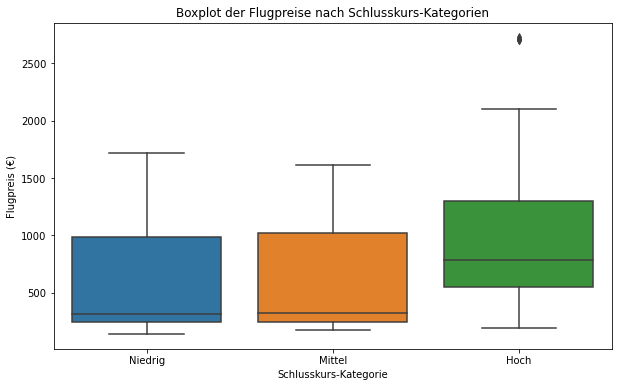

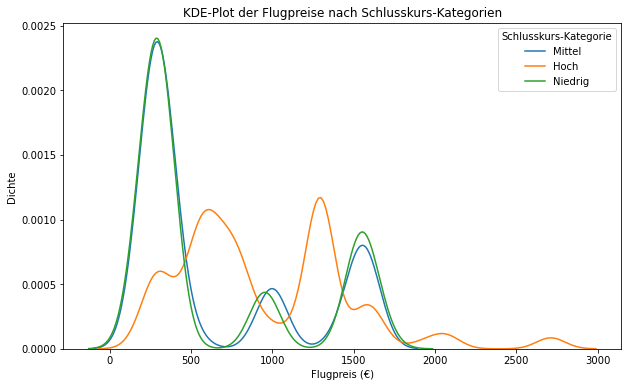

In [45]:
# Boxplot der Flugpreise nach Schlusskurs-Kategorien
plt.figure(figsize=(10, 6))
sns.boxplot(x='close_cat', y='price', data=df)
plt.title('Boxplot der Flugpreise nach Schlusskurs-Kategorien')
plt.xlabel('Schlusskurs-Kategorie')
plt.ylabel('Flugpreis (€)')
plt.show()

# KDE-Plot der Flugpreise nach Schlusskurs-Kategorien
plt.figure(figsize=(10, 6))
for category in df['close_cat'].unique():
    subset = df[df['close_cat'] == category]['price']
    sns.kdeplot(subset, label=category, bw_adjust=0.5)

plt.title('KDE-Plot der Flugpreise nach Schlusskurs-Kategorien')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Schlusskurs-Kategorie')
plt.show()

In [46]:
# Überprüfen auf NaN-Werte in den relevanten Spalten
print(df[['price', 'close_cat']].isna().sum())

# Entfernen von Zeilen mit NaN-Werten in 'price' oder 'close_cat'
df = df.dropna(subset=['price', 'close_cat'])

# Gruppieren der Daten nach den Kategorien in 'close_cat'
close_groups = [df[df['close_cat'] == cat]['price'] for cat in df['close_cat'].unique()]

# Kruskal-Wallis-Test durchführen
kruskal_stat, kruskal_p_value = kruskal(*close_groups)

print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
print(f"P-Wert: {kruskal_p_value}")

# Wenn signifikante Unterschiede gefunden wurden, dann führe den Post-hoc Dunn-Test durch
if kruskal_p_value < 0.05:
    print("\nSignifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.")
    
    # Post-hoc Dunn-Test durchführen
    posthoc_results = sp.posthoc_dunn(df, val_col='price', group_col='close_cat', p_adjust='bonferroni')
    
    # Ergebnis anzeigen
    print("\nPost-hoc Dunn-Test Ergebnisse:")
    print(posthoc_results)
else:
    print("\nKeine signifikanten Unterschiede zwischen den Gruppen. Ein Post-hoc-Test ist nicht erforderlich.")

price          0
close_cat    127
dtype: int64
Kruskal-Wallis-Statistik: 61.42293366966919
P-Wert: 4.593877630402542e-14

Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.

Post-hoc Dunn-Test Ergebnisse:
              Niedrig        Mittel          Hoch
Niedrig  1.000000e+00  1.000000e+00  4.511632e-12
Mittel   1.000000e+00  1.000000e+00  2.291984e-10
Hoch     4.511632e-12  2.291984e-10  1.000000e+00


                      count        mean         std    min     q25  median  \
close_cat_simplified                                                         
Niedrig/Mittel          448  649.873125  536.505263  141.0  243.65  316.49   
Hoch                    213  946.796150  515.134094  193.0  548.00  789.00   

                           q75     max  
close_cat_simplified                    
Niedrig/Mittel        1013.565  1713.9  
Hoch                  1296.000  2725.0  


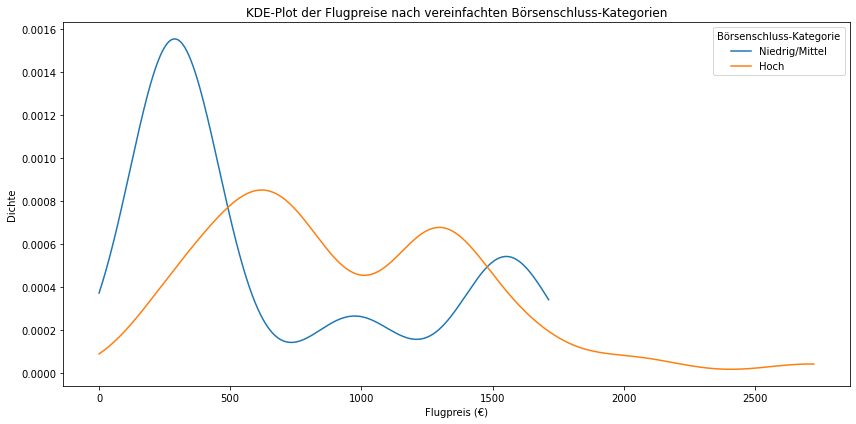


Kruskal-Wallis-Statistik (vereinfacht): 61.40032389468001
P-Wert (vereinfacht): 4.657338957855806e-15

Signifikante Unterschiede zwischen den neu gruppierten Börsenschluss-Kategorien nachgewiesen.


In [47]:
# Zusammenfassen der Kategorien 'Niedrig' und 'Mittel' in eine neue Kategorie 'Niedrig/Mittel'
df['close_cat_simplified'] = df['close_cat'].replace({
    'Niedrig': 'Niedrig/Mittel',
    'Mittel': 'Niedrig/Mittel',
    'Hoch': 'Hoch'
})

# Deskriptive Statistiken der Preise nach den neuen Kategorien
close_stats_simplified = df.groupby('close_cat_simplified').agg(
    count=('price', 'count'),
    mean=('price', 'mean'),
    std=('price', 'std'),
    min=('price', 'min'),
    q25=('price', lambda x: x.quantile(0.25)),
    median=('price', 'median'),
    q75=('price', lambda x: x.quantile(0.75)),
    max=('price', 'max')
)

# Ausgabe der deskriptiven Statistiken
print(close_stats_simplified)

# KDE-Plot für die neuen Kategorien erstellen
plt.figure(figsize=(12, 6))

for category in df['close_cat_simplified'].unique():
    subset = df[df['close_cat_simplified'] == category]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Sicherstellen, dass keine negativen Dichten angezeigt werden
    
        plt.plot(price_range, density, label=category)

plt.title('KDE-Plot der Flugpreise nach vereinfachten Börsenschluss-Kategorien')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Börsenschluss-Kategorie')
plt.tight_layout()
plt.show()

# Durchführung des Kruskal-Wallis-Tests für die vereinfachten Kategorien
simplified_close_groups = [df[df['close_cat_simplified'] == cat]['price'] for cat in df['close_cat_simplified'].unique()]
kruskal_stat_simplified, kruskal_p_value_simplified = kruskal(*simplified_close_groups)

print(f"\nKruskal-Wallis-Statistik (vereinfacht): {kruskal_stat_simplified}")
print(f"P-Wert (vereinfacht): {kruskal_p_value_simplified}")

# Überprüfen, ob signifikante Unterschiede bestehen
if kruskal_p_value_simplified < 0.05:
    print("\nSignifikante Unterschiede zwischen den neu gruppierten Börsenschluss-Kategorien nachgewiesen.")
else:
    print("\nKeine signifikanten Unterschiede zwischen den neu gruppierten Börsenschluss-Kategorien.")

# Handelsvolumen

### Handelsvolumen und dessen Einfluss auf die Flugpreise

#### Deskriptive Statistik:
Die folgende Tabelle zeigt die deskriptiven Statistiken des **Handelsvolumens** (in Einheiten) und deren Einfluss auf die Flugpreise:

| Kennzahl         | Wert            |
|------------------|-----------------|
| Anzahl           | 661             |
| Mittelwert       | 2.56 Mio.       |
| Standardabweichung | 1.50 Mio.      |
| Minimum          | 0.00            |
| 25%-Quantil      | 0.88 Mio.       |
| Median           | 2.80 Mio.       |
| 75%-Quantil      | 3.56 Mio.       |

#### Hypothese:
**H0**: Es gibt **keine signifikanten Unterschiede** in den Flugpreisen zwischen den Kategorien des Handelsvolumens.  
**H1**: Mindestens eine Handelsvolumenkategorie führt zu **signifikant unterschiedlichen** Flugpreisen.

#### Kruskal-Wallis-Test:
- **Kruskal-Wallis-Statistik**: 49.02  
- **P-Wert**: 2.27e-11  

Da der P-Wert kleiner als 0.05 ist, lehnen wir die Nullhypothese ab. Es gibt **signifikante Unterschiede** zwischen den Handelsvolumenkategorien hinsichtlich der Flugpreise.

#### Post-hoc Dunn-Test:
| Vergleich    | P-Wert        | Signifikant |
|--------------|---------------|-------------|
| Hoch vs. Mittel  | 7.284989e-01 | Nein        |
| Hoch vs. Niedrig | 1.079367e-07 | Ja          |
| Mittel vs. Niedrig | 2.085517e-10 | Ja          |

Der **Post-hoc Dunn-Test** zeigt, dass es signifikante Unterschiede zwischen der Kategorie "Niedrig" und den beiden Kategorien "Mittel" und "Hoch" gibt. Zwischen "Mittel" und "Hoch" gibt es jedoch **keine signifikanten Unterschiede**.

#### Neue Gruppierung:
Auf Basis der Ergebnisse haben wir die Handelsvolumenkategorien wie folgt neu gruppiert:

- **Nicht-Niedrig**: Zusammenfassung der Kategorien "Mittel" und "Hoch"
- **Niedrig**: Beibehaltung der Kategorie "Niedrig"

Diese Neugruppierung fokussiert auf die signifikanten Unterschiede und vereinfacht die Analyse.


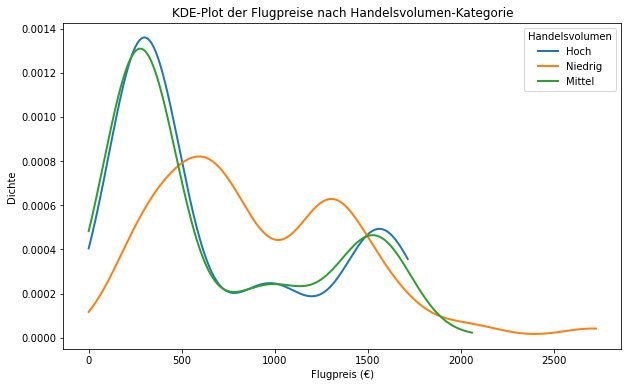

count    6.610000e+02
mean     2.563856e+06
std      1.499145e+06
min      0.000000e+00
25%      8.820550e+05
50%      2.802881e+06
75%      3.558680e+06
max      5.924554e+06
Name: Volume, dtype: float64


In [48]:
# Handelsvolumen in Kategorien einteilen
def categorize_volume(volume):
    if volume < df['Volume'].quantile(0.33):
        return 'Niedrig'
    elif volume < df['Volume'].quantile(0.67):
        return 'Mittel'
    else:
        return 'Hoch'

df['volume_cat'] = df['Volume'].apply(categorize_volume)


# Kategorien für das Handelsvolumen
volume_categories = df['volume_cat'].unique()

# KDE-Plot für jede Handelsvolumen-Kategorie
plt.figure(figsize=(10, 6))

for category in volume_categories:
    subset = df[df['volume_cat'] == category]['price']
    
    if len(subset) > 1:
        kde = gaussian_kde(subset)
        price_range = np.linspace(0, subset.max(), 1000)
        density = kde(price_range)
        density[density < 0] = 0  # Negative Dichten auf 0 setzen
    
        plt.plot(price_range, density, label=category, linewidth=2)

plt.title('KDE-Plot der Flugpreise nach Handelsvolumen-Kategorie')
plt.xlabel('Flugpreis (€)')
plt.ylabel('Dichte')
plt.legend(title='Handelsvolumen')
plt.show()


volume_stats = df['Volume'].describe()
print(volume_stats)

In [49]:
# Sicherstellen, dass jede Kategorie ausreichend Daten enthält
valid_categories = df['volume_cat'].value_counts()[df['volume_cat'].value_counts() > 1].index.tolist()

# Falls nötig, nur die gültigen Kategorien für den Test verwenden
if len(valid_categories) >= 2:
    # Kruskal-Wallis-Test durchführen
    kruskal_stat, kruskal_p_value = stats.kruskal(
        *[df[df['volume_cat'] == cat]['price'] for cat in valid_categories]
    )
    print(f"Kruskal-Wallis-Statistik: {kruskal_stat}")
    print(f"P-Wert: {kruskal_p_value}")
    
    # Wenn der Kruskal-Wallis-Test signifikant ist, Post-hoc Dunn-Test durchführen
    if kruskal_p_value < 0.05:
        print("Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.")
        
        # Post-hoc Dunn-Test durchführen
        posthoc_dunn = sp.posthoc_dunn(
            df[df['volume_cat'].isin(valid_categories)],  # Nur gültige Kategorien verwenden
            val_col='price', 
            group_col='volume_cat', 
            p_adjust='bonferroni'
        )
        
        # Ergebnis anzeigen
        print("Post-hoc Dunn-Test Ergebnisse:\n", posthoc_dunn)
    else:
        print("Keine signifikanten Unterschiede zwischen den Gruppen.")
else:
    print("Nicht genügend Daten in den Kategorien für einen validen Test.")

Kruskal-Wallis-Statistik: 49.01531928232594
P-Wert: 2.2722632966887286e-11
Signifikante Unterschiede zwischen den Gruppen nachgewiesen, Durchführung des Post-hoc Dunn-Tests.
Post-hoc Dunn-Test Ergebnisse:
                  Hoch        Mittel       Niedrig
Hoch     1.000000e+00  7.284989e-01  1.079367e-07
Mittel   7.284989e-01  1.000000e+00  2.085517e-10
Niedrig  1.079367e-07  2.085517e-10  1.000000e+00


Nicht-Niedrig    446
Niedrig          215
Name: volume_cat_simplified, dtype: int64
                       count        mean         std    min       25%    50%  \
volume_cat_simplified                                                          
Nicht-Niedrig          446.0  662.440269  539.752085  141.0  251.1175  333.6   
Niedrig                215.0  917.964558  522.991430  193.0  548.0000  789.0   

                             75%     max  
volume_cat_simplified                     
Nicht-Niedrig          1019.9175  2059.0  
Niedrig                1295.0000  2725.0  


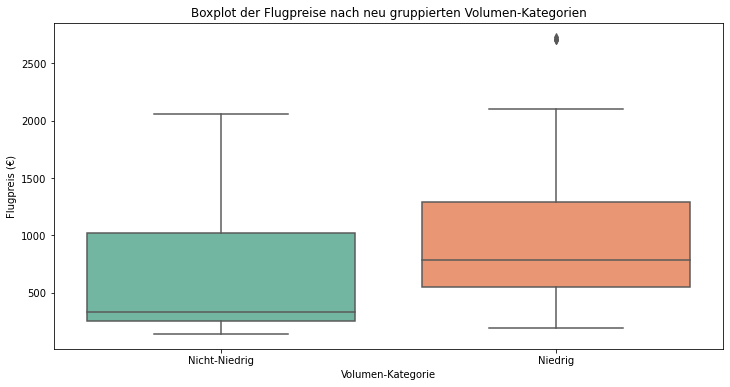

Kruskal-Wallis-Statistik (vereinfacht): 47.65124702431315
P-Wert (vereinfacht): 5.091983689999938e-12


In [50]:
# Neue Gruppierung basierend auf den Dunn-Test-Ergebnissen
df['volume_cat_simplified'] = df['volume_cat'].replace({
    'Mittel': 'Nicht-Niedrig',
    'Hoch': 'Nicht-Niedrig',
    'Niedrig': 'Niedrig'
})

# Überprüfen der neuen Gruppierung
print(df['volume_cat_simplified'].value_counts())

# Deskriptive Statistiken für die neu gruppierten Volumen-Kategorien
desc_stats_volume_simplified = df.groupby('volume_cat_simplified')['price'].describe()
print(desc_stats_volume_simplified)

# Boxplot der Flugpreise nach neu gruppierten Volumen-Kategorien
plt.figure(figsize=(12, 6))
sns.boxplot(x='volume_cat_simplified', y='price', data=df, palette='Set2')
plt.title('Boxplot der Flugpreise nach neu gruppierten Volumen-Kategorien')
plt.xlabel('Volumen-Kategorie')
plt.ylabel('Flugpreis (€)')
plt.show()

# Kruskal-Wallis-Test für die neu gruppierten Volumen-Kategorien
groups_simplified = [df[df['volume_cat_simplified'] == cat]['price'] for cat in df['volume_cat_simplified'].unique()]
kruskal_stat_simplified, kruskal_p_value_simplified = kruskal(*groups_simplified)

print(f"Kruskal-Wallis-Statistik (vereinfacht): {kruskal_stat_simplified}")
print(f"P-Wert (vereinfacht): {kruskal_p_value_simplified}")

# Model

### Erklärung der Anpassung: Kategorische Variablen vs. Numerische Variablen

In unserer Analyse haben wir ursprünglich viele Variablen als **kategorische Variablen** betrachtet, indem wir sie in Gruppen eingeteilt haben. Der Grund dafür war, dass diese Gruppierungen eine einfachere Interpretation ermöglichten. Zum Beispiel wurde die Transitzeit in Gruppen wie "kurz" und "lang" unterteilt, um leichter zu erkennen, ob bestimmte Kategorien einen Einfluss auf den Preis haben. Für die **explorative Datenanalyse** und insbesondere für die Durchführung von **Hypothesentests** wie dem Kruskal-Wallis-Test und dem Post-hoc Dunn-Test macht dies Sinn. Durch die Gruppierung konnten wir testen, ob unterschiedliche Kategorien eines Features signifikante Unterschiede im Preis hervorrufen.

**Kategorische Betrachtung war sinnvoll, weil:**
1. **Einfache Interpretation**: Mit klaren Kategorien lässt sich leicht erkennen, welche Gruppen von Variablen einen Einfluss auf den Preis haben.
2. **Hypothesentests**: Um Unterschiede zwischen Gruppen zu identifizieren, sind solche Gruppierungen notwendig, da der Kruskal-Wallis-Test für **nicht-normal verteilte** Daten verwendet wird.
3. **Reduzierung der Modellkomplexität**: Durch die Gruppierung wurde verhindert, dass zu viele numerische Variablen das Modell überlasten.

### Warum numerische Variablen?
Nachdem wir die Feature-Analyse abgeschlossen hatten, haben wir erkannt, dass einige der **kontinuierlichen Variablen** (wie die Transitzeit oder Reisezeit) möglicherweise besser direkt als **numerische Variablen** behandelt werden sollten. Dies liegt daran, dass eine kontinuierliche Beziehung zum Preis besteht, und es oft sinnvoller ist, den vollen Informationsgehalt der Daten zu nutzen, anstatt ihn in Kategorien zu unterteilen.

**Warum jetzt numerische Betrachtung sinnvoll ist:**
1. **Präzisere Modellierung**: Kontinuierliche Variablen wie die tatsächliche Transitzeit in Minuten geben genauere Informationen als grobe Kategorien.
2. **Verbesserte Vorhersagekraft**: Die lineare Regression profitiert von numerischen Variablen, da sie präzisere Schätzungen ermöglicht, indem sie feine Unterschiede zwischen Beobachtungen berücksichtigt.
3. **Vermeidung von Informationsverlust**: Durch die Kategorisierung werden wertvolle Informationen über den genauen Zusammenhang zwischen der Variablen und dem Preis möglicherweise verloren.

## Ergebnisse der linearen Regression nach Standardisierung

In dieser Analyse haben wir die lineare Regression verwendet, um den Einfluss verschiedener Faktoren auf den Flugpreis zu quantifizieren. Um eine bessere Vergleichbarkeit der Koeffizienten zu gewährleisten, wurden die Variablen mit der **Standardisierungsmethode** transformiert. Durch die Standardisierung haben alle Variablen einen Mittelwert von 0 und eine Standardabweichung von 1, wodurch die Koeffizienten als direkte Indikatoren für die Stärke des Einflusses einer Variablen interpretiert werden können.

### Tabelle der Koeffizienten der Einflussfaktoren (nach Standardisierung)

| **Einflussfaktor**                             | **Koeffizient (nach Standardisierung)** |
|------------------------------------------------|-----------------------------------------|
| departure_time_minutes                         | -55.28                                  |
| arrival_time_minutes                           | 60.68                                   |
| travel_duration_minutes                        | 814.85                                  |
| tavg_departure                                 | 34.65                                   |
| tavg_destination                               | -119.13                                 |
| Close                                          | 110.09                                  |
| Volume                                         | 2.50                                    |
| transit_duration_minutes                       | -475.02                                 |
| destination_category_Inland                    | 139.14                                  |
| destination_category_International             | 44.82                                   |
| wind_speed_group_simplified_Niedrig-Mittel      | -0.20                                   |
| close_cat_simplified_Hoch                      | 1.66                                    |
| volume_cat_simplified_Niedrig                  | 24.11                                   |

### Interpretation der Koeffizienten

1. **travel_duration_minutes** (+814.85):  
   Die Reisedauer hat den stärksten Einfluss auf den Flugpreis. Eine Zunahme der Reisedauer um eine Standardabweichung (ca. 180 Minuten) führt zu einem Anstieg des Preises um etwa 815 €. Dieser hohe Wert zeigt, dass längere Flüge deutlich teurer sind.

2. **tavg_destination** (-119.13):  
   Die durchschnittliche Temperatur am Zielort hat einen negativen Einfluss. Pro Standardabweichung (ca. 5°C) sinkt der Preis um etwa 119 €. Dies deutet darauf hin, dass wärmere Ziele tendenziell günstiger sind.

3. **Close** (+110.09):  
   Ein höherer Schlusskurs der Aktie steht im Zusammenhang mit einem Preisanstieg. Für jede Standardabweichung (ca. 250 € im Preis) steigt der Preis um etwa 110 €.

4. **transit_duration_minutes** (-475.02):  
   Eine längere Transitzeit senkt den Preis. Pro Standardabweichung Transitzeit (ca. 180 Minuten) sinkt der Preis um etwa 475 €.

5. **destination_category_Inland** (+139.14):  
   Inlandflüge sind im Vergleich zu internationalen oder europäischen Flügen teurer und erhöhen den Preis im Durchschnitt um ca. 139 €.

6. **arrival_time_minutes** (+60.68) und **departure_time_minutes** (-55.28):  
   Spätere Ankunftszeiten erhöhen den Preis leicht, während spätere Abflugzeiten den Preis senken.

7. **tavg_departure** (+34.65):  
   Eine höhere Durchschnittstemperatur am Abflugort hat einen moderaten positiven Einfluss auf den Preis, wobei der Preis pro Standardabweichung (ca. 2°C) um etwa 35 € steigt.

8. **Volume** (+2.50):  
   Das Handelsvolumen zeigt einen geringen, aber positiven Einfluss auf den Preis.

9. **wind_speed_group_simplified_Niedrig-Mittel** (-0.20):  
   Die Windgeschwindigkeit hat keinen signifikanten Einfluss auf den Preis.

10. **close_cat_simplified_Hoch** (+1.66):  
    Ein hoher Schlusskurs wirkt sich minimal positiv auf den Preis aus.

11. **volume_cat_simplified_Niedrig** (+24.11):  
    Niedriges Handelsvolumen hat einen positiven Effekt auf den Preis.

### Modellgüte

- **R²**: 0.709 – Das Modell erklärt etwa 71 % der Varianz der Flugpreise, was für diese Art von Analyse als solide betrachtet werden kann. Dies zeigt, dass die gewählten Einflussfaktoren eine gute Erklärung für die Preisunterschiede bieten.
  
- **Mean Squared Error (MSE)**: 87,002 – Der durchschnittliche quadratische Fehler des Modells zeigt die Differenz zwischen den vorhergesagten und tatsächlichen Preisen an. Ein niedrigerer MSE ist wünschenswert, aber der aktuelle Wert deutet auf eine solide Modellgüte hin.
  
- **Cross-Validation MSE**: 94,115 – Das Modell zeigt auch in der Kreuzvalidierung eine akzeptable Leistung, was bedeutet, dass es gut generalisiert und nicht überangepasst ist.

### Schlussfolgerungen und weitere Vorgehensweise

- **Große Einflussfaktoren**: Die Reisedauer hat den größten Einfluss auf die Flugpreise, gefolgt von der Transitdauer und der Temperatur am Zielort. Dies ist intuitiv nachvollziehbar, da längere Flüge und Transitzeiten die Kosten erhöhen.
  
- **Mittlere Einflussfaktoren**: Variablen wie der Schlusskurs, die Durchschnittstemperatur am Abflugort und das Reiseziel haben ebenfalls signifikante, aber moderate Auswirkungen auf den Preis.

- **Kaum Einfluss**: Windgeschwindigkeit und Handelsvolumen haben nur einen geringen bis vernachlässigbaren Einfluss auf den Flugpreis.

Insgesamt zeigt die Analyse, dass unsere Feature-Auswahl sinnvoll ist und das Modell eine gute Vorhersagekraft für die Flugpreise hat. Zukünftige Arbeiten könnten andere Regressionsmodelle testen oder die Interaktionen zwischen den Variablen genauer untersuchen.


### Schlussfolgerungen und nächste Schritte:
Obwohl das Modell bereits eine akzeptable Varianz erklärt (R² von 70.9%), bleibt noch Spielraum für Verbesserungen. Die genaue Analyse der Features zeigt, dass einige Variablen, wie die **Reisedauer** und **Transitzeit**, einen großen Einfluss auf die Preise haben. Andere Variablen wie die **Windgeschwindigkeit** oder **Abflugzeit** spielen eine geringere Rolle.

Das Modell könnte weiter verbessert werden, indem zusätzliche **interaktive Effekte** zwischen Variablen betrachtet werden oder **nicht-lineare Modelle** verwendet werden. Darüber hinaus könnten weitere Daten über längere Zeiträume und mehr Airlines gesammelt werden, um die Vorhersagekraft und Generalisierbarkeit zu erhöhen.

In [55]:
# Auswahl der Features und Zielvariable
X = df[['departure_time_minutes', 'arrival_time_minutes', 'travel_duration_minutes',
        'tavg_departure', 'tavg_destination', 'Close', 'Volume',
        'transit_duration_minutes', 'destination_category', 
        'wind_speed_group_simplified', 'close_cat_simplified', 'volume_cat_simplified']]

# One-Hot-Encoding der kategorialen Variablen
X_encoded = pd.get_dummies(X, drop_first=True)

# Abhängige Variable (y)
y = df['price']

# Überprüfen und Entfernen von NaN-Werten
X_encoded = X_encoded.dropna()
y = y[X_encoded.index]

# Standardisierung der Features (Skalierung)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Lineares Regressionsmodell erstellen
model = LinearRegression()

# Modell trainieren
model.fit(X_scaled, y)

# Vorhersagen erstellen
y_pred = model.predict(X_scaled)

# Modellgüte beurteilen
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()

# Ergebnisse ausgeben
print(f"R^2: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Cross-Validation MSE: {cv_mse}")
print("\nKoeffizienten der Einflussfaktoren (nach Standardisierung):")
print(pd.Series(model.coef_, index=X_encoded.columns))

R^2: 0.7090350802203554
Mean Squared Error: 87002.49394981236
Cross-Validation MSE: 94115.53399140555

Koeffizienten der Einflussfaktoren (nach Standardisierung):
departure_time_minutes                        -55.280340
arrival_time_minutes                           60.677723
travel_duration_minutes                       814.854610
tavg_departure                                 34.649974
tavg_destination                             -119.134291
Close                                         110.090563
Volume                                          2.504886
transit_duration_minutes                     -475.018078
destination_category_Inland                   139.144867
destination_category_International             44.819557
wind_speed_group_simplified_Niedrig-Mittel     -0.195096
close_cat_simplified_Hoch                       1.658259
volume_cat_simplified_Niedrig                  24.111527
dtype: float64
